In [1]:
%matplotlib inline

import os
while 'source' not in os.listdir():
    os.chdir('..')
os.chdir('source')

FORCE = False

import gpu

In [2]:
from util import getHashId


props={
    'path'          : 'data',
    'seed'          : 42,
    'split'         : 0.8,
    'test_split'    : 0.5,
    'control'       : False,
    'huntington'    : True,
    'left'          : False,
    'right'         : True,
    'threshold'     : None,
    'binarize'      : False,
    'not_connected' : False,
    'single'        : None,
    'features'      : [],
    'features_vox'  : [],
    'radiomics'     : [
        #{'sp':'native','im':'t1','fe':['b25'],'fi':['roi','t1_mask']},
    ],
    'space'         : 'native',
    'radiomics_vox' : [
        {'im':'t1','fe':['k5_b25','k7_b25','k9_b25','k11_b25','k13_b25','k15_b25','k17_b25','k19_b25','k21_b25']},
    ],
    'rad_vox_norm'  : 'norm',
    'inps'          : [],
    'features_clin' : None,
    'outp'          : 'diffusion_fa',
    'balance_data'  : False,
    'exclude'       : ['t1t2','normalized'],
    'include_warp'  : True,
    'collapse_max'  : False,
    'collapse_bin'  : False,
}

architecture={
    'activation'    : 'sigmoid',
    'layers'        : [1024,512,256,128],
    'loss'          : 'MSE',
    'learning_rate' : 0.001,
    'batch_size'    : 10000,
    'patience'      : 7,
}

HASHID, HASH = getHashId(architecture,props)
print(HASH)

sigmoid_10000_1024_512_256_128_0001_MSE_7_0_0_0_0_0_t1t2_normalized_e_n_e_1_1_e_0_0_diffusion_fa_data_norm_e_k5_b25_k7_b25_k9_b25_k11_b25_k13_b25_k15_b25_k17_b25_k19_b25_k21_b25_t1_1_42_n_native_08_05_n


In [3]:
from DataGenerator import DataGenerator

gen = DataGenerator(**props)
train, val, test = gen.getData()

print('train')
print(train[0].shape)
print(train[1].shape)
print('validation')
print(val[0].shape)
print(val[1].shape)
print('test')
print(test[0].shape)
print(test[1].shape)

train
(236358, 828)
(236358, 1)
validation
(44338, 828)
(44338, 1)
test
(22164, 828)
(22164, 1)


In [4]:
from Model import *
from tensorflow.keras.optimizers import Adam

path = props['path']+'/models'

stop = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=architecture['patience'],
)
save = tf.keras.callbacks.ModelCheckpoint(
    filepath=path+'/{}.weights.h5'.format(HASHID),
    monitor='val_loss',
    mode='min',
    save_best_only=True,
    save_weights_only=True,
)

model = buildModel(train[0].shape[1], train[1].shape[1], activation=architecture['activation'], layers=architecture['layers'])

model.compile(loss=locals()[architecture['loss']], optimizer=Adam(learning_rate=architecture['learning_rate']), jit_compile=True, metrics=[STD,MAE])

model.summary()

Model: "FFN"


_________________________________________________________________


 Layer (type)                Output Shape              Param #   


 input_1 (InputLayer)        [(None, 828)]             0         


 dense (Dense)               (None, 1024)              848896    


 dense_1 (Dense)             (None, 512)               524800    


 dense_2 (Dense)             (None, 256)               131328    


 dense_3 (Dense)             (None, 128)               32896     


 dense_4 (Dense)             (None, 1)                 129       


Total params: 1538049 (5.87 MB)


Trainable params: 1538049 (5.87 MB)


Non-trainable params: 0 (0.00 Byte)


_________________________________________________________________


In [5]:
import os
from util import pickleSave

if FORCE or not os.path.exists(path+'/{}.pkl'.format(HASHID)):
    history = model.fit(DataWrapper(train,architecture['batch_size']),
        validation_data=DataWrapper(val,architecture['batch_size'],False),
        epochs=10000,
        verbose=1,
        callbacks = [save,stop],
    )
    pickleSave(path+'/{}.pkl'.format(HASHID), history.history)

model.load_weights(path+'/{}.weights.h5'.format(HASHID))

Epoch 1/10000


 1/24 [>.............................] - ETA: 33s - loss: 0.0336 - STD: 1.3128e-04 - MAE: 0.1651

 2/24 [=>............................] - ETA: 17s - loss: 0.0258 - STD: 2.1192e-04 - MAE: 0.1250

 5/24 [=====>........................] - ETA: 4s - loss: 0.0239 - STD: 2.3541e-04 - MAE: 0.1178 

 6/24 [======>.......................] - ETA: 3s - loss: 0.0236 - STD: 2.4016e-04 - MAE: 0.1166

 7/24 [=======>......................] - ETA: 2s - loss: 0.0229 - STD: 2.4895e-04 - MAE: 0.1141

 8/24 [=========>....................] - ETA: 2s - loss: 0.0219 - STD: 2.6241e-04 - MAE: 0.1110

 9/24 [==========>...................] - ETA: 2s - loss: 0.0209 - STD: 2.8135e-04 - MAE: 0.1079

10/24 [===========>..................] - ETA: 1s - loss: 0.0199 - STD: 3.0390e-04 - MAE: 0.1056

11/24 [============>.................] - ETA: 1s - loss: 0.0193 - STD: 3.2949e-04 - MAE: 0.1047

12/24 [==============>...............] - ETA: 1s - loss: 0.0190 - STD: 3.5562e-04 - MAE: 0.1048

13/24 [===============>..............] - ETA: 1s - loss: 0.0187 - STD: 3.8201e-04 - MAE: 0.1051

14/24 [================>.............] - ETA: 1s - loss: 0.0184 - STD: 4.0790e-04 - MAE: 0.1050

15/24 [=================>............] - ETA: 0s - loss: 0.0181 - STD: 4.3192e-04 - MAE: 0.1044

16/24 [===================>..........] - ETA: 0s - loss: 0.0177 - STD: 4.5308e-04 - MAE: 0.1034

17/24 [====================>.........] - ETA: 0s - loss: 0.0174 - STD: 4.7210e-04 - MAE: 0.1023

18/24 [=====================>........] - ETA: 0s - loss: 0.0171 - STD: 4.8861e-04 - MAE: 0.1011

19/24 [======================>.......] - ETA: 0s - loss: 0.0169 - STD: 5.0321e-04 - MAE: 0.1002

20/24 [========================>.....] - ETA: 0s - loss: 0.0167 - STD: 5.1687e-04 - MAE: 0.0993

21/24 [=========================>....] - ETA: 0s - loss: 0.0166 - STD: 5.3069e-04 - MAE: 0.0987

22/24 [==========================>...] - ETA: 0s - loss: 0.0164 - STD: 5.4490e-04 - MAE: 0.0980

23/24 [===========================>..] - ETA: 0s - loss: 0.0163 - STD: 5.6056e-04 - MAE: 0.0973

24/24 [==============================] - ETA: 0s - loss: 0.0161 - STD: 5.7752e-04 - MAE: 0.0967

24/24 [==============================] - 4s 117ms/step - loss: 0.0161 - STD: 5.7752e-04 - MAE: 0.0967 - val_loss: 0.0138 - val_STD: 0.0011 - val_MAE: 0.0935


Epoch 2/10000


 1/24 [>.............................] - ETA: 2s - loss: 0.0120 - STD: 0.0011 - MAE: 0.0827

 2/24 [=>............................] - ETA: 1s - loss: 0.0121 - STD: 0.0011 - MAE: 0.0841

 3/24 [==>...........................] - ETA: 1s - loss: 0.0119 - STD: 0.0011 - MAE: 0.0846

 4/24 [====>.........................] - ETA: 1s - loss: 0.0120 - STD: 0.0012 - MAE: 0.0859

 5/24 [=====>........................] - ETA: 1s - loss: 0.0121 - STD: 0.0012 - MAE: 0.0870

 6/24 [======>.......................] - ETA: 1s - loss: 0.0121 - STD: 0.0013 - MAE: 0.0877

 7/24 [=======>......................] - ETA: 0s - loss: 0.0121 - STD: 0.0013 - MAE: 0.0879

 8/24 [=========>....................] - ETA: 0s - loss: 0.0121 - STD: 0.0013 - MAE: 0.0879

 9/24 [==========>...................] - ETA: 0s - loss: 0.0121 - STD: 0.0013 - MAE: 0.0878

10/24 [===========>..................] - ETA: 0s - loss: 0.0121 - STD: 0.0014 - MAE: 0.0876

11/24 [============>.................] - ETA: 0s - loss: 0.0121 - STD: 0.0014 - MAE: 0.0872

12/24 [==============>...............] - ETA: 0s - loss: 0.0121 - STD: 0.0014 - MAE: 0.0868

13/24 [===============>..............] - ETA: 0s - loss: 0.0121 - STD: 0.0014 - MAE: 0.0864

14/24 [================>.............] - ETA: 0s - loss: 0.0121 - STD: 0.0015 - MAE: 0.0862

15/24 [=================>............] - ETA: 0s - loss: 0.0122 - STD: 0.0015 - MAE: 0.0860

16/24 [===================>..........] - ETA: 0s - loss: 0.0121 - STD: 0.0015 - MAE: 0.0857

17/24 [====================>.........] - ETA: 0s - loss: 0.0121 - STD: 0.0016 - MAE: 0.0856

18/24 [=====================>........] - ETA: 0s - loss: 0.0121 - STD: 0.0016 - MAE: 0.0855

19/24 [======================>.......] - ETA: 0s - loss: 0.0121 - STD: 0.0017 - MAE: 0.0854

20/24 [========================>.....] - ETA: 0s - loss: 0.0120 - STD: 0.0017 - MAE: 0.0855

21/24 [=========================>....] - ETA: 0s - loss: 0.0120 - STD: 0.0018 - MAE: 0.0854

22/24 [==========================>...] - ETA: 0s - loss: 0.0120 - STD: 0.0018 - MAE: 0.0855

23/24 [===========================>..] - ETA: 0s - loss: 0.0120 - STD: 0.0019 - MAE: 0.0856

24/24 [==============================] - 2s 62ms/step - loss: 0.0120 - STD: 0.0019 - MAE: 0.0856 - val_loss: 0.0132 - val_STD: 0.0034 - val_MAE: 0.0940


Epoch 3/10000


 1/24 [>.............................] - ETA: 2s - loss: 0.0114 - STD: 0.0034 - MAE: 0.0838

 2/24 [=>............................] - ETA: 1s - loss: 0.0117 - STD: 0.0035 - MAE: 0.0845

 3/24 [==>...........................] - ETA: 1s - loss: 0.0116 - STD: 0.0036 - MAE: 0.0837

 4/24 [====>.........................] - ETA: 1s - loss: 0.0116 - STD: 0.0037 - MAE: 0.0834

 5/24 [=====>........................] - ETA: 1s - loss: 0.0116 - STD: 0.0038 - MAE: 0.0832

 6/24 [======>.......................] - ETA: 1s - loss: 0.0116 - STD: 0.0039 - MAE: 0.0831

 7/24 [=======>......................] - ETA: 0s - loss: 0.0116 - STD: 0.0040 - MAE: 0.0831

 8/24 [=========>....................] - ETA: 0s - loss: 0.0116 - STD: 0.0041 - MAE: 0.0831

 9/24 [==========>...................] - ETA: 0s - loss: 0.0116 - STD: 0.0043 - MAE: 0.0832

10/24 [===========>..................] - ETA: 0s - loss: 0.0116 - STD: 0.0045 - MAE: 0.0833

11/24 [============>.................] - ETA: 0s - loss: 0.0116 - STD: 0.0046 - MAE: 0.0833

12/24 [==============>...............] - ETA: 0s - loss: 0.0115 - STD: 0.0048 - MAE: 0.0833

13/24 [===============>..............] - ETA: 0s - loss: 0.0115 - STD: 0.0050 - MAE: 0.0834

14/24 [================>.............] - ETA: 0s - loss: 0.0115 - STD: 0.0052 - MAE: 0.0834

15/24 [=================>............] - ETA: 0s - loss: 0.0115 - STD: 0.0054 - MAE: 0.0834

16/24 [===================>..........] - ETA: 0s - loss: 0.0115 - STD: 0.0056 - MAE: 0.0833

17/24 [====================>.........] - ETA: 0s - loss: 0.0115 - STD: 0.0058 - MAE: 0.0833

19/24 [======================>.......] - ETA: 0s - loss: 0.0114 - STD: 0.0063 - MAE: 0.0831

20/24 [========================>.....] - ETA: 0s - loss: 0.0114 - STD: 0.0066 - MAE: 0.0830

21/24 [=========================>....] - ETA: 0s - loss: 0.0114 - STD: 0.0069 - MAE: 0.0829

22/24 [==========================>...] - ETA: 0s - loss: 0.0114 - STD: 0.0072 - MAE: 0.0828

23/24 [===========================>..] - ETA: 0s - loss: 0.0113 - STD: 0.0075 - MAE: 0.0827

24/24 [==============================] - ETA: 0s - loss: 0.0113 - STD: 0.0079 - MAE: 0.0826

24/24 [==============================] - 2s 63ms/step - loss: 0.0113 - STD: 0.0079 - MAE: 0.0826 - val_loss: 0.0120 - val_STD: 0.0176 - val_MAE: 0.0903


Epoch 4/10000


 1/24 [>.............................] - ETA: 2s - loss: 0.0102 - STD: 0.0176 - MAE: 0.0793

 2/24 [=>............................] - ETA: 1s - loss: 0.0102 - STD: 0.0183 - MAE: 0.0795

 3/24 [==>...........................] - ETA: 1s - loss: 0.0103 - STD: 0.0189 - MAE: 0.0797

 4/24 [====>.........................] - ETA: 1s - loss: 0.0102 - STD: 0.0197 - MAE: 0.0795

 5/24 [=====>........................] - ETA: 1s - loss: 0.0103 - STD: 0.0203 - MAE: 0.0795

 6/24 [======>.......................] - ETA: 1s - loss: 0.0102 - STD: 0.0211 - MAE: 0.0795

 7/24 [=======>......................] - ETA: 0s - loss: 0.0102 - STD: 0.0219 - MAE: 0.0793

 8/24 [=========>....................] - ETA: 0s - loss: 0.0102 - STD: 0.0228 - MAE: 0.0792

 9/24 [==========>...................] - ETA: 0s - loss: 0.0101 - STD: 0.0237 - MAE: 0.0790

10/24 [===========>..................] - ETA: 0s - loss: 0.0101 - STD: 0.0246 - MAE: 0.0788

11/24 [============>.................] - ETA: 0s - loss: 0.0101 - STD: 0.0255 - MAE: 0.0788

12/24 [==============>...............] - ETA: 0s - loss: 0.0100 - STD: 0.0265 - MAE: 0.0786

13/24 [===============>..............] - ETA: 0s - loss: 0.0100 - STD: 0.0274 - MAE: 0.0785

14/24 [================>.............] - ETA: 0s - loss: 0.0100 - STD: 0.0284 - MAE: 0.0783

15/24 [=================>............] - ETA: 0s - loss: 0.0100 - STD: 0.0293 - MAE: 0.0782

16/24 [===================>..........] - ETA: 0s - loss: 0.0099 - STD: 0.0303 - MAE: 0.0781

17/24 [====================>.........] - ETA: 0s - loss: 0.0099 - STD: 0.0311 - MAE: 0.0779

18/24 [=====================>........] - ETA: 0s - loss: 0.0099 - STD: 0.0320 - MAE: 0.0778

19/24 [======================>.......] - ETA: 0s - loss: 0.0099 - STD: 0.0329 - MAE: 0.0777

20/24 [========================>.....] - ETA: 0s - loss: 0.0098 - STD: 0.0337 - MAE: 0.0776

21/24 [=========================>....] - ETA: 0s - loss: 0.0098 - STD: 0.0344 - MAE: 0.0774

22/24 [==========================>...] - ETA: 0s - loss: 0.0098 - STD: 0.0351 - MAE: 0.0772

23/24 [===========================>..] - ETA: 0s - loss: 0.0098 - STD: 0.0358 - MAE: 0.0771

24/24 [==============================] - 2s 62ms/step - loss: 0.0097 - STD: 0.0364 - MAE: 0.0769 - val_loss: 0.0105 - val_STD: 0.0497 - val_MAE: 0.0837


Epoch 5/10000


 1/24 [>.............................] - ETA: 2s - loss: 0.0090 - STD: 0.0501 - MAE: 0.0731

 2/24 [=>............................] - ETA: 1s - loss: 0.0090 - STD: 0.0502 - MAE: 0.0730

 3/24 [==>...........................] - ETA: 1s - loss: 0.0090 - STD: 0.0501 - MAE: 0.0730

 4/24 [====>.........................] - ETA: 1s - loss: 0.0090 - STD: 0.0501 - MAE: 0.0731

 5/24 [=====>........................] - ETA: 1s - loss: 0.0090 - STD: 0.0499 - MAE: 0.0731

 6/24 [======>.......................] - ETA: 0s - loss: 0.0090 - STD: 0.0496 - MAE: 0.0731

 7/24 [=======>......................] - ETA: 0s - loss: 0.0089 - STD: 0.0494 - MAE: 0.0728

 8/24 [=========>....................] - ETA: 0s - loss: 0.0089 - STD: 0.0492 - MAE: 0.0728

 9/24 [==========>...................] - ETA: 0s - loss: 0.0089 - STD: 0.0492 - MAE: 0.0727

10/24 [===========>..................] - ETA: 0s - loss: 0.0089 - STD: 0.0490 - MAE: 0.0726

11/24 [============>.................] - ETA: 0s - loss: 0.0089 - STD: 0.0490 - MAE: 0.0726

12/24 [==============>...............] - ETA: 0s - loss: 0.0089 - STD: 0.0490 - MAE: 0.0725

13/24 [===============>..............] - ETA: 0s - loss: 0.0089 - STD: 0.0490 - MAE: 0.0725

14/24 [================>.............] - ETA: 0s - loss: 0.0088 - STD: 0.0491 - MAE: 0.0724

15/24 [=================>............] - ETA: 0s - loss: 0.0088 - STD: 0.0492 - MAE: 0.0724

16/24 [===================>..........] - ETA: 0s - loss: 0.0088 - STD: 0.0493 - MAE: 0.0724

18/24 [=====================>........] - ETA: 0s - loss: 0.0088 - STD: 0.0497 - MAE: 0.0722

19/24 [======================>.......] - ETA: 0s - loss: 0.0088 - STD: 0.0498 - MAE: 0.0720

20/24 [========================>.....] - ETA: 0s - loss: 0.0087 - STD: 0.0500 - MAE: 0.0719

21/24 [=========================>....] - ETA: 0s - loss: 0.0087 - STD: 0.0502 - MAE: 0.0719

22/24 [==========================>...] - ETA: 0s - loss: 0.0087 - STD: 0.0504 - MAE: 0.0718

23/24 [===========================>..] - ETA: 0s - loss: 0.0087 - STD: 0.0506 - MAE: 0.0717

24/24 [==============================] - ETA: 0s - loss: 0.0087 - STD: 0.0508 - MAE: 0.0716

24/24 [==============================] - 1s 61ms/step - loss: 0.0087 - STD: 0.0508 - MAE: 0.0716 - val_loss: 0.0090 - val_STD: 0.0560 - val_MAE: 0.0767


Epoch 6/10000


 1/24 [>.............................] - ETA: 2s - loss: 0.0079 - STD: 0.0549 - MAE: 0.0676

 2/24 [=>............................] - ETA: 1s - loss: 0.0080 - STD: 0.0550 - MAE: 0.0678

 3/24 [==>...........................] - ETA: 1s - loss: 0.0080 - STD: 0.0554 - MAE: 0.0681

 4/24 [====>.........................] - ETA: 1s - loss: 0.0079 - STD: 0.0560 - MAE: 0.0682

 5/24 [=====>........................] - ETA: 1s - loss: 0.0079 - STD: 0.0561 - MAE: 0.0680

 6/24 [======>.......................] - ETA: 0s - loss: 0.0079 - STD: 0.0562 - MAE: 0.0677

 7/24 [=======>......................] - ETA: 0s - loss: 0.0078 - STD: 0.0565 - MAE: 0.0676

 8/24 [=========>....................] - ETA: 0s - loss: 0.0078 - STD: 0.0570 - MAE: 0.0674

 9/24 [==========>...................] - ETA: 0s - loss: 0.0077 - STD: 0.0574 - MAE: 0.0672

10/24 [===========>..................] - ETA: 0s - loss: 0.0077 - STD: 0.0577 - MAE: 0.0670

11/24 [============>.................] - ETA: 0s - loss: 0.0076 - STD: 0.0582 - MAE: 0.0669

12/24 [==============>...............] - ETA: 0s - loss: 0.0076 - STD: 0.0587 - MAE: 0.0667

13/24 [===============>..............] - ETA: 0s - loss: 0.0076 - STD: 0.0590 - MAE: 0.0665

14/24 [================>.............] - ETA: 0s - loss: 0.0076 - STD: 0.0596 - MAE: 0.0665

15/24 [=================>............] - ETA: 0s - loss: 0.0075 - STD: 0.0602 - MAE: 0.0663

16/24 [===================>..........] - ETA: 0s - loss: 0.0075 - STD: 0.0606 - MAE: 0.0662

17/24 [====================>.........] - ETA: 0s - loss: 0.0075 - STD: 0.0611 - MAE: 0.0661

18/24 [=====================>........] - ETA: 0s - loss: 0.0075 - STD: 0.0616 - MAE: 0.0660

19/24 [======================>.......] - ETA: 0s - loss: 0.0074 - STD: 0.0620 - MAE: 0.0658

20/24 [========================>.....] - ETA: 0s - loss: 0.0074 - STD: 0.0624 - MAE: 0.0656

21/24 [=========================>....] - ETA: 0s - loss: 0.0074 - STD: 0.0628 - MAE: 0.0655

22/24 [==========================>...] - ETA: 0s - loss: 0.0074 - STD: 0.0630 - MAE: 0.0654

24/24 [==============================] - ETA: 0s - loss: 0.0073 - STD: 0.0636 - MAE: 0.0652

24/24 [==============================] - 2s 63ms/step - loss: 0.0073 - STD: 0.0636 - MAE: 0.0652 - val_loss: 0.0074 - val_STD: 0.0724 - val_MAE: 0.0675


Epoch 7/10000


 1/24 [>.............................] - ETA: 2s - loss: 0.0070 - STD: 0.0676 - MAE: 0.0618

 2/24 [=>............................] - ETA: 1s - loss: 0.0069 - STD: 0.0685 - MAE: 0.0622

 3/24 [==>...........................] - ETA: 1s - loss: 0.0069 - STD: 0.0690 - MAE: 0.0625

 4/24 [====>.........................] - ETA: 1s - loss: 0.0069 - STD: 0.0684 - MAE: 0.0626

 5/24 [=====>........................] - ETA: 1s - loss: 0.0069 - STD: 0.0685 - MAE: 0.0624

 6/24 [======>.......................] - ETA: 1s - loss: 0.0068 - STD: 0.0687 - MAE: 0.0625

 7/24 [=======>......................] - ETA: 1s - loss: 0.0068 - STD: 0.0683 - MAE: 0.0623

 8/24 [=========>....................] - ETA: 0s - loss: 0.0068 - STD: 0.0684 - MAE: 0.0624

 9/24 [==========>...................] - ETA: 0s - loss: 0.0068 - STD: 0.0687 - MAE: 0.0624

10/24 [===========>..................] - ETA: 0s - loss: 0.0068 - STD: 0.0681 - MAE: 0.0621

11/24 [============>.................] - ETA: 0s - loss: 0.0068 - STD: 0.0683 - MAE: 0.0620

12/24 [==============>...............] - ETA: 0s - loss: 0.0067 - STD: 0.0685 - MAE: 0.0620

14/24 [================>.............] - ETA: 0s - loss: 0.0067 - STD: 0.0686 - MAE: 0.0619

15/24 [=================>............] - ETA: 0s - loss: 0.0067 - STD: 0.0687 - MAE: 0.0618

16/24 [===================>..........] - ETA: 0s - loss: 0.0067 - STD: 0.0687 - MAE: 0.0616

17/24 [====================>.........] - ETA: 0s - loss: 0.0067 - STD: 0.0690 - MAE: 0.0616

18/24 [=====================>........] - ETA: 0s - loss: 0.0067 - STD: 0.0690 - MAE: 0.0615

19/24 [======================>.......] - ETA: 0s - loss: 0.0067 - STD: 0.0692 - MAE: 0.0615

20/24 [========================>.....] - ETA: 0s - loss: 0.0066 - STD: 0.0694 - MAE: 0.0614

21/24 [=========================>....] - ETA: 0s - loss: 0.0066 - STD: 0.0695 - MAE: 0.0613

22/24 [==========================>...] - ETA: 0s - loss: 0.0066 - STD: 0.0697 - MAE: 0.0613

23/24 [===========================>..] - ETA: 0s - loss: 0.0066 - STD: 0.0697 - MAE: 0.0612

24/24 [==============================] - ETA: 0s - loss: 0.0066 - STD: 0.0699 - MAE: 0.0611

24/24 [==============================] - 2s 70ms/step - loss: 0.0066 - STD: 0.0699 - MAE: 0.0611 - val_loss: 0.0067 - val_STD: 0.0780 - val_MAE: 0.0640


Epoch 8/10000


 1/24 [>.............................] - ETA: 2s - loss: 0.0064 - STD: 0.0733 - MAE: 0.0592

 2/24 [=>............................] - ETA: 2s - loss: 0.0065 - STD: 0.0729 - MAE: 0.0599

 3/24 [==>...........................] - ETA: 1s - loss: 0.0065 - STD: 0.0735 - MAE: 0.0600

 4/24 [====>.........................] - ETA: 1s - loss: 0.0065 - STD: 0.0727 - MAE: 0.0597

 5/24 [=====>........................] - ETA: 1s - loss: 0.0064 - STD: 0.0734 - MAE: 0.0599

 6/24 [======>.......................] - ETA: 1s - loss: 0.0065 - STD: 0.0726 - MAE: 0.0597

 7/24 [=======>......................] - ETA: 1s - loss: 0.0065 - STD: 0.0733 - MAE: 0.0599

 8/24 [=========>....................] - ETA: 1s - loss: 0.0065 - STD: 0.0731 - MAE: 0.0598

10/24 [===========>..................] - ETA: 1s - loss: 0.0064 - STD: 0.0730 - MAE: 0.0598

11/24 [============>.................] - ETA: 0s - loss: 0.0064 - STD: 0.0727 - MAE: 0.0596

12/24 [==============>...............] - ETA: 0s - loss: 0.0064 - STD: 0.0728 - MAE: 0.0595

13/24 [===============>..............] - ETA: 0s - loss: 0.0064 - STD: 0.0730 - MAE: 0.0596

14/24 [================>.............] - ETA: 0s - loss: 0.0064 - STD: 0.0725 - MAE: 0.0595

15/24 [=================>............] - ETA: 0s - loss: 0.0064 - STD: 0.0729 - MAE: 0.0595

16/24 [===================>..........] - ETA: 0s - loss: 0.0064 - STD: 0.0730 - MAE: 0.0596

17/24 [====================>.........] - ETA: 0s - loss: 0.0064 - STD: 0.0726 - MAE: 0.0595

18/24 [=====================>........] - ETA: 0s - loss: 0.0064 - STD: 0.0727 - MAE: 0.0594

19/24 [======================>.......] - ETA: 0s - loss: 0.0064 - STD: 0.0728 - MAE: 0.0594

20/24 [========================>.....] - ETA: 0s - loss: 0.0063 - STD: 0.0726 - MAE: 0.0593

21/24 [=========================>....] - ETA: 0s - loss: 0.0063 - STD: 0.0726 - MAE: 0.0592

22/24 [==========================>...] - ETA: 0s - loss: 0.0063 - STD: 0.0727 - MAE: 0.0592

23/24 [===========================>..] - ETA: 0s - loss: 0.0063 - STD: 0.0727 - MAE: 0.0591

24/24 [==============================] - ETA: 0s - loss: 0.0063 - STD: 0.0727 - MAE: 0.0590

24/24 [==============================] - 2s 75ms/step - loss: 0.0063 - STD: 0.0727 - MAE: 0.0590 - val_loss: 0.0062 - val_STD: 0.0782 - val_MAE: 0.0619


Epoch 9/10000


 1/24 [>.............................] - ETA: 2s - loss: 0.0061 - STD: 0.0743 - MAE: 0.0583

 2/24 [=>............................] - ETA: 1s - loss: 0.0059 - STD: 0.0730 - MAE: 0.0575

 4/24 [====>.........................] - ETA: 1s - loss: 0.0060 - STD: 0.0741 - MAE: 0.0578

 5/24 [=====>........................] - ETA: 1s - loss: 0.0060 - STD: 0.0741 - MAE: 0.0577

 6/24 [======>.......................] - ETA: 1s - loss: 0.0060 - STD: 0.0744 - MAE: 0.0575

 7/24 [=======>......................] - ETA: 0s - loss: 0.0060 - STD: 0.0747 - MAE: 0.0576

 8/24 [=========>....................] - ETA: 0s - loss: 0.0060 - STD: 0.0749 - MAE: 0.0575

 9/24 [==========>...................] - ETA: 0s - loss: 0.0060 - STD: 0.0748 - MAE: 0.0574

10/24 [===========>..................] - ETA: 0s - loss: 0.0060 - STD: 0.0750 - MAE: 0.0575

11/24 [============>.................] - ETA: 0s - loss: 0.0060 - STD: 0.0750 - MAE: 0.0574

12/24 [==============>...............] - ETA: 0s - loss: 0.0060 - STD: 0.0751 - MAE: 0.0573

13/24 [===============>..............] - ETA: 0s - loss: 0.0060 - STD: 0.0751 - MAE: 0.0572

14/24 [================>.............] - ETA: 0s - loss: 0.0060 - STD: 0.0752 - MAE: 0.0573

15/24 [=================>............] - ETA: 0s - loss: 0.0060 - STD: 0.0751 - MAE: 0.0572

16/24 [===================>..........] - ETA: 0s - loss: 0.0060 - STD: 0.0754 - MAE: 0.0575

17/24 [====================>.........] - ETA: 0s - loss: 0.0060 - STD: 0.0749 - MAE: 0.0574

18/24 [=====================>........] - ETA: 0s - loss: 0.0060 - STD: 0.0752 - MAE: 0.0575

19/24 [======================>.......] - ETA: 0s - loss: 0.0060 - STD: 0.0750 - MAE: 0.0574

20/24 [========================>.....] - ETA: 0s - loss: 0.0060 - STD: 0.0750 - MAE: 0.0574

21/24 [=========================>....] - ETA: 0s - loss: 0.0060 - STD: 0.0752 - MAE: 0.0574

22/24 [==========================>...] - ETA: 0s - loss: 0.0060 - STD: 0.0749 - MAE: 0.0574

23/24 [===========================>..] - ETA: 0s - loss: 0.0060 - STD: 0.0751 - MAE: 0.0575

24/24 [==============================] - ETA: 0s - loss: 0.0060 - STD: 0.0752 - MAE: 0.0574

24/24 [==============================] - 2s 66ms/step - loss: 0.0060 - STD: 0.0752 - MAE: 0.0574 - val_loss: 0.0060 - val_STD: 0.0756 - val_MAE: 0.0586


Epoch 10/10000


 1/24 [>.............................] - ETA: 2s - loss: 0.0064 - STD: 0.0719 - MAE: 0.0565

 2/24 [=>............................] - ETA: 1s - loss: 0.0063 - STD: 0.0771 - MAE: 0.0587

 3/24 [==>...........................] - ETA: 1s - loss: 0.0064 - STD: 0.0733 - MAE: 0.0580

 4/24 [====>.........................] - ETA: 1s - loss: 0.0062 - STD: 0.0742 - MAE: 0.0577

 5/24 [=====>........................] - ETA: 1s - loss: 0.0062 - STD: 0.0755 - MAE: 0.0585

 7/24 [=======>......................] - ETA: 1s - loss: 0.0062 - STD: 0.0734 - MAE: 0.0579

 8/24 [=========>....................] - ETA: 1s - loss: 0.0063 - STD: 0.0750 - MAE: 0.0591

 9/24 [==========>...................] - ETA: 0s - loss: 0.0064 - STD: 0.0733 - MAE: 0.0592

10/24 [===========>..................] - ETA: 0s - loss: 0.0064 - STD: 0.0726 - MAE: 0.0589

11/24 [============>.................] - ETA: 0s - loss: 0.0066 - STD: 0.0738 - MAE: 0.0600

12/24 [==============>...............] - ETA: 0s - loss: 0.0065 - STD: 0.0734 - MAE: 0.0596

13/24 [===============>..............] - ETA: 0s - loss: 0.0065 - STD: 0.0725 - MAE: 0.0595

14/24 [================>.............] - ETA: 0s - loss: 0.0065 - STD: 0.0728 - MAE: 0.0594

15/24 [=================>............] - ETA: 0s - loss: 0.0065 - STD: 0.0734 - MAE: 0.0598

16/24 [===================>..........] - ETA: 0s - loss: 0.0065 - STD: 0.0729 - MAE: 0.0597

17/24 [====================>.........] - ETA: 0s - loss: 0.0065 - STD: 0.0724 - MAE: 0.0595

18/24 [=====================>........] - ETA: 0s - loss: 0.0065 - STD: 0.0726 - MAE: 0.0594

19/24 [======================>.......] - ETA: 0s - loss: 0.0065 - STD: 0.0729 - MAE: 0.0597

20/24 [========================>.....] - ETA: 0s - loss: 0.0065 - STD: 0.0726 - MAE: 0.0595

21/24 [=========================>....] - ETA: 0s - loss: 0.0064 - STD: 0.0723 - MAE: 0.0593

22/24 [==========================>...] - ETA: 0s - loss: 0.0064 - STD: 0.0725 - MAE: 0.0592

23/24 [===========================>..] - ETA: 0s - loss: 0.0064 - STD: 0.0728 - MAE: 0.0593

24/24 [==============================] - ETA: 0s - loss: 0.0064 - STD: 0.0727 - MAE: 0.0592

24/24 [==============================] - 2s 69ms/step - loss: 0.0064 - STD: 0.0727 - MAE: 0.0592 - val_loss: 0.0063 - val_STD: 0.0706 - val_MAE: 0.0595


Epoch 11/10000


 1/24 [>.............................] - ETA: 2s - loss: 0.0062 - STD: 0.0672 - MAE: 0.0559

 2/24 [=>............................] - ETA: 1s - loss: 0.0058 - STD: 0.0704 - MAE: 0.0554

 3/24 [==>...........................] - ETA: 1s - loss: 0.0059 - STD: 0.0732 - MAE: 0.0572

 4/24 [====>.........................] - ETA: 1s - loss: 0.0059 - STD: 0.0737 - MAE: 0.0570

 5/24 [=====>........................] - ETA: 1s - loss: 0.0059 - STD: 0.0729 - MAE: 0.0568

 6/24 [======>.......................] - ETA: 1s - loss: 0.0059 - STD: 0.0733 - MAE: 0.0568

 7/24 [=======>......................] - ETA: 1s - loss: 0.0059 - STD: 0.0743 - MAE: 0.0571

 8/24 [=========>....................] - ETA: 1s - loss: 0.0059 - STD: 0.0746 - MAE: 0.0569

 9/24 [==========>...................] - ETA: 1s - loss: 0.0059 - STD: 0.0743 - MAE: 0.0567

10/24 [===========>..................] - ETA: 0s - loss: 0.0059 - STD: 0.0745 - MAE: 0.0566

11/24 [============>.................] - ETA: 0s - loss: 0.0059 - STD: 0.0749 - MAE: 0.0567

12/24 [==============>...............] - ETA: 0s - loss: 0.0059 - STD: 0.0751 - MAE: 0.0567

13/24 [===============>..............] - ETA: 0s - loss: 0.0059 - STD: 0.0751 - MAE: 0.0566

14/24 [================>.............] - ETA: 0s - loss: 0.0058 - STD: 0.0753 - MAE: 0.0565

15/24 [=================>............] - ETA: 0s - loss: 0.0058 - STD: 0.0757 - MAE: 0.0565

16/24 [===================>..........] - ETA: 0s - loss: 0.0058 - STD: 0.0757 - MAE: 0.0565

17/24 [====================>.........] - ETA: 0s - loss: 0.0058 - STD: 0.0757 - MAE: 0.0564

18/24 [=====================>........] - ETA: 0s - loss: 0.0058 - STD: 0.0759 - MAE: 0.0564

19/24 [======================>.......] - ETA: 0s - loss: 0.0058 - STD: 0.0761 - MAE: 0.0564

20/24 [========================>.....] - ETA: 0s - loss: 0.0058 - STD: 0.0760 - MAE: 0.0563

22/24 [==========================>...] - ETA: 0s - loss: 0.0058 - STD: 0.0761 - MAE: 0.0563

23/24 [===========================>..] - ETA: 0s - loss: 0.0058 - STD: 0.0762 - MAE: 0.0563

24/24 [==============================] - ETA: 0s - loss: 0.0058 - STD: 0.0761 - MAE: 0.0563

24/24 [==============================] - 2s 73ms/step - loss: 0.0058 - STD: 0.0761 - MAE: 0.0563 - val_loss: 0.0056 - val_STD: 0.0808 - val_MAE: 0.0579


Epoch 12/10000


 1/24 [>.............................] - ETA: 2s - loss: 0.0059 - STD: 0.0768 - MAE: 0.0565

 2/24 [=>............................] - ETA: 1s - loss: 0.0058 - STD: 0.0788 - MAE: 0.0567

 3/24 [==>...........................] - ETA: 1s - loss: 0.0057 - STD: 0.0778 - MAE: 0.0560

 4/24 [====>.........................] - ETA: 1s - loss: 0.0057 - STD: 0.0769 - MAE: 0.0557

 5/24 [=====>........................] - ETA: 1s - loss: 0.0057 - STD: 0.0770 - MAE: 0.0554

 6/24 [======>.......................] - ETA: 1s - loss: 0.0057 - STD: 0.0774 - MAE: 0.0556

 7/24 [=======>......................] - ETA: 1s - loss: 0.0056 - STD: 0.0774 - MAE: 0.0556

 9/24 [==========>...................] - ETA: 0s - loss: 0.0057 - STD: 0.0771 - MAE: 0.0555

10/24 [===========>..................] - ETA: 0s - loss: 0.0057 - STD: 0.0774 - MAE: 0.0556

11/24 [============>.................] - ETA: 0s - loss: 0.0057 - STD: 0.0773 - MAE: 0.0556

12/24 [==============>...............] - ETA: 0s - loss: 0.0057 - STD: 0.0772 - MAE: 0.0554

13/24 [===============>..............] - ETA: 0s - loss: 0.0057 - STD: 0.0774 - MAE: 0.0555

14/24 [================>.............] - ETA: 0s - loss: 0.0057 - STD: 0.0775 - MAE: 0.0554

15/24 [=================>............] - ETA: 0s - loss: 0.0057 - STD: 0.0775 - MAE: 0.0554

16/24 [===================>..........] - ETA: 0s - loss: 0.0057 - STD: 0.0776 - MAE: 0.0554

17/24 [====================>.........] - ETA: 0s - loss: 0.0056 - STD: 0.0778 - MAE: 0.0554

18/24 [=====================>........] - ETA: 0s - loss: 0.0056 - STD: 0.0778 - MAE: 0.0553

19/24 [======================>.......] - ETA: 0s - loss: 0.0056 - STD: 0.0777 - MAE: 0.0553

20/24 [========================>.....] - ETA: 0s - loss: 0.0056 - STD: 0.0778 - MAE: 0.0553

21/24 [=========================>....] - ETA: 0s - loss: 0.0056 - STD: 0.0777 - MAE: 0.0552

22/24 [==========================>...] - ETA: 0s - loss: 0.0056 - STD: 0.0777 - MAE: 0.0552

23/24 [===========================>..] - ETA: 0s - loss: 0.0056 - STD: 0.0778 - MAE: 0.0552

24/24 [==============================] - ETA: 0s - loss: 0.0056 - STD: 0.0778 - MAE: 0.0552

24/24 [==============================] - 2s 71ms/step - loss: 0.0056 - STD: 0.0778 - MAE: 0.0552 - val_loss: 0.0055 - val_STD: 0.0816 - val_MAE: 0.0568


Epoch 13/10000


 1/24 [>.............................] - ETA: 2s - loss: 0.0055 - STD: 0.0779 - MAE: 0.0543

 2/24 [=>............................] - ETA: 1s - loss: 0.0056 - STD: 0.0783 - MAE: 0.0548

 3/24 [==>...........................] - ETA: 1s - loss: 0.0056 - STD: 0.0782 - MAE: 0.0548

 4/24 [====>.........................] - ETA: 1s - loss: 0.0056 - STD: 0.0780 - MAE: 0.0547

 5/24 [=====>........................] - ETA: 1s - loss: 0.0055 - STD: 0.0787 - MAE: 0.0547

 6/24 [======>.......................] - ETA: 1s - loss: 0.0055 - STD: 0.0786 - MAE: 0.0547

 7/24 [=======>......................] - ETA: 1s - loss: 0.0056 - STD: 0.0787 - MAE: 0.0547

 8/24 [=========>....................] - ETA: 1s - loss: 0.0056 - STD: 0.0791 - MAE: 0.0548

 9/24 [==========>...................] - ETA: 0s - loss: 0.0055 - STD: 0.0790 - MAE: 0.0547

10/24 [===========>..................] - ETA: 0s - loss: 0.0056 - STD: 0.0791 - MAE: 0.0548

11/24 [============>.................] - ETA: 0s - loss: 0.0055 - STD: 0.0795 - MAE: 0.0548

12/24 [==============>...............] - ETA: 0s - loss: 0.0055 - STD: 0.0791 - MAE: 0.0547

13/24 [===============>..............] - ETA: 0s - loss: 0.0055 - STD: 0.0792 - MAE: 0.0547

14/24 [================>.............] - ETA: 0s - loss: 0.0055 - STD: 0.0796 - MAE: 0.0548

15/24 [=================>............] - ETA: 0s - loss: 0.0056 - STD: 0.0791 - MAE: 0.0547

16/24 [===================>..........] - ETA: 0s - loss: 0.0056 - STD: 0.0791 - MAE: 0.0547

17/24 [====================>.........] - ETA: 0s - loss: 0.0056 - STD: 0.0794 - MAE: 0.0548

18/24 [=====================>........] - ETA: 0s - loss: 0.0056 - STD: 0.0789 - MAE: 0.0547

19/24 [======================>.......] - ETA: 0s - loss: 0.0056 - STD: 0.0789 - MAE: 0.0548

20/24 [========================>.....] - ETA: 0s - loss: 0.0056 - STD: 0.0792 - MAE: 0.0550

21/24 [=========================>....] - ETA: 0s - loss: 0.0056 - STD: 0.0787 - MAE: 0.0550

22/24 [==========================>...] - ETA: 0s - loss: 0.0056 - STD: 0.0786 - MAE: 0.0549

24/24 [==============================] - ETA: 0s - loss: 0.0057 - STD: 0.0785 - MAE: 0.0554

24/24 [==============================] - 2s 71ms/step - loss: 0.0057 - STD: 0.0785 - MAE: 0.0554 - val_loss: 0.0056 - val_STD: 0.0772 - val_MAE: 0.0561


Epoch 14/10000


 1/24 [>.............................] - ETA: 2s - loss: 0.0060 - STD: 0.0744 - MAE: 0.0546

 2/24 [=>............................] - ETA: 1s - loss: 0.0069 - STD: 0.0838 - MAE: 0.0631

 3/24 [==>...........................] - ETA: 1s - loss: 0.0071 - STD: 0.0765 - MAE: 0.0622

 4/24 [====>.........................] - ETA: 1s - loss: 0.0070 - STD: 0.0733 - MAE: 0.0609

 5/24 [=====>........................] - ETA: 1s - loss: 0.0071 - STD: 0.0768 - MAE: 0.0628

 6/24 [======>.......................] - ETA: 1s - loss: 0.0068 - STD: 0.0764 - MAE: 0.0613

 7/24 [=======>......................] - ETA: 1s - loss: 0.0068 - STD: 0.0745 - MAE: 0.0608

 8/24 [=========>....................] - ETA: 1s - loss: 0.0067 - STD: 0.0743 - MAE: 0.0600

 9/24 [==========>...................] - ETA: 1s - loss: 0.0067 - STD: 0.0757 - MAE: 0.0608

10/24 [===========>..................] - ETA: 0s - loss: 0.0066 - STD: 0.0752 - MAE: 0.0601

11/24 [============>.................] - ETA: 0s - loss: 0.0066 - STD: 0.0742 - MAE: 0.0597

12/24 [==============>...............] - ETA: 0s - loss: 0.0065 - STD: 0.0742 - MAE: 0.0594

13/24 [===============>..............] - ETA: 0s - loss: 0.0064 - STD: 0.0748 - MAE: 0.0596

14/24 [================>.............] - ETA: 0s - loss: 0.0064 - STD: 0.0745 - MAE: 0.0592

15/24 [=================>............] - ETA: 0s - loss: 0.0064 - STD: 0.0739 - MAE: 0.0590

16/24 [===================>..........] - ETA: 0s - loss: 0.0063 - STD: 0.0739 - MAE: 0.0587

17/24 [====================>.........] - ETA: 0s - loss: 0.0063 - STD: 0.0743 - MAE: 0.0588

19/24 [======================>.......] - ETA: 0s - loss: 0.0063 - STD: 0.0739 - MAE: 0.0585

20/24 [========================>.....] - ETA: 0s - loss: 0.0062 - STD: 0.0740 - MAE: 0.0583

21/24 [=========================>....] - ETA: 0s - loss: 0.0062 - STD: 0.0744 - MAE: 0.0584

22/24 [==========================>...] - ETA: 0s - loss: 0.0062 - STD: 0.0745 - MAE: 0.0582

23/24 [===========================>..] - ETA: 0s - loss: 0.0062 - STD: 0.0744 - MAE: 0.0580

24/24 [==============================] - ETA: 0s - loss: 0.0061 - STD: 0.0744 - MAE: 0.0578

24/24 [==============================] - 2s 73ms/step - loss: 0.0061 - STD: 0.0744 - MAE: 0.0578 - val_loss: 0.0057 - val_STD: 0.0852 - val_MAE: 0.0593


Epoch 15/10000


 1/24 [>.............................] - ETA: 2s - loss: 0.0057 - STD: 0.0817 - MAE: 0.0570

 2/24 [=>............................] - ETA: 1s - loss: 0.0055 - STD: 0.0811 - MAE: 0.0562

 3/24 [==>...........................] - ETA: 1s - loss: 0.0055 - STD: 0.0793 - MAE: 0.0554

 4/24 [====>.........................] - ETA: 1s - loss: 0.0056 - STD: 0.0784 - MAE: 0.0552

 5/24 [=====>........................] - ETA: 1s - loss: 0.0055 - STD: 0.0794 - MAE: 0.0553

 6/24 [======>.......................] - ETA: 1s - loss: 0.0055 - STD: 0.0799 - MAE: 0.0554

 7/24 [=======>......................] - ETA: 1s - loss: 0.0056 - STD: 0.0791 - MAE: 0.0553

 8/24 [=========>....................] - ETA: 1s - loss: 0.0056 - STD: 0.0787 - MAE: 0.0550

 9/24 [==========>...................] - ETA: 1s - loss: 0.0056 - STD: 0.0793 - MAE: 0.0551

10/24 [===========>..................] - ETA: 0s - loss: 0.0055 - STD: 0.0794 - MAE: 0.0551

11/24 [============>.................] - ETA: 0s - loss: 0.0056 - STD: 0.0790 - MAE: 0.0550

12/24 [==============>...............] - ETA: 0s - loss: 0.0056 - STD: 0.0788 - MAE: 0.0549

13/24 [===============>..............] - ETA: 0s - loss: 0.0056 - STD: 0.0792 - MAE: 0.0550

14/24 [================>.............] - ETA: 0s - loss: 0.0056 - STD: 0.0794 - MAE: 0.0550

15/24 [=================>............] - ETA: 0s - loss: 0.0055 - STD: 0.0790 - MAE: 0.0548

16/24 [===================>..........] - ETA: 0s - loss: 0.0055 - STD: 0.0789 - MAE: 0.0547

17/24 [====================>.........] - ETA: 0s - loss: 0.0056 - STD: 0.0791 - MAE: 0.0549

18/24 [=====================>........] - ETA: 0s - loss: 0.0055 - STD: 0.0791 - MAE: 0.0548

19/24 [======================>.......] - ETA: 0s - loss: 0.0055 - STD: 0.0788 - MAE: 0.0548

20/24 [========================>.....] - ETA: 0s - loss: 0.0055 - STD: 0.0788 - MAE: 0.0548

21/24 [=========================>....] - ETA: 0s - loss: 0.0055 - STD: 0.0791 - MAE: 0.0548

22/24 [==========================>...] - ETA: 0s - loss: 0.0055 - STD: 0.0791 - MAE: 0.0548

23/24 [===========================>..] - ETA: 0s - loss: 0.0055 - STD: 0.0789 - MAE: 0.0547

24/24 [==============================] - ETA: 0s - loss: 0.0055 - STD: 0.0789 - MAE: 0.0547

24/24 [==============================] - 2s 76ms/step - loss: 0.0055 - STD: 0.0789 - MAE: 0.0547 - val_loss: 0.0054 - val_STD: 0.0852 - val_MAE: 0.0574


Epoch 16/10000


 1/24 [>.............................] - ETA: 2s - loss: 0.0053 - STD: 0.0815 - MAE: 0.0548

 2/24 [=>............................] - ETA: 1s - loss: 0.0053 - STD: 0.0797 - MAE: 0.0540

 3/24 [==>...........................] - ETA: 1s - loss: 0.0054 - STD: 0.0787 - MAE: 0.0538

 4/24 [====>.........................] - ETA: 1s - loss: 0.0053 - STD: 0.0791 - MAE: 0.0539

 5/24 [=====>........................] - ETA: 1s - loss: 0.0053 - STD: 0.0791 - MAE: 0.0540

 6/24 [======>.......................] - ETA: 1s - loss: 0.0053 - STD: 0.0788 - MAE: 0.0539

 7/24 [=======>......................] - ETA: 1s - loss: 0.0053 - STD: 0.0790 - MAE: 0.0539

 8/24 [=========>....................] - ETA: 1s - loss: 0.0053 - STD: 0.0792 - MAE: 0.0539

 9/24 [==========>...................] - ETA: 1s - loss: 0.0053 - STD: 0.0792 - MAE: 0.0539

10/24 [===========>..................] - ETA: 0s - loss: 0.0053 - STD: 0.0792 - MAE: 0.0539

11/24 [============>.................] - ETA: 0s - loss: 0.0054 - STD: 0.0792 - MAE: 0.0539

12/24 [==============>...............] - ETA: 0s - loss: 0.0053 - STD: 0.0793 - MAE: 0.0538

13/24 [===============>..............] - ETA: 0s - loss: 0.0053 - STD: 0.0793 - MAE: 0.0537

14/24 [================>.............] - ETA: 0s - loss: 0.0053 - STD: 0.0794 - MAE: 0.0537

15/24 [=================>............] - ETA: 0s - loss: 0.0053 - STD: 0.0795 - MAE: 0.0537

16/24 [===================>..........] - ETA: 0s - loss: 0.0053 - STD: 0.0795 - MAE: 0.0537

17/24 [====================>.........] - ETA: 0s - loss: 0.0053 - STD: 0.0796 - MAE: 0.0537

18/24 [=====================>........] - ETA: 0s - loss: 0.0054 - STD: 0.0797 - MAE: 0.0537

20/24 [========================>.....] - ETA: 0s - loss: 0.0053 - STD: 0.0797 - MAE: 0.0537

21/24 [=========================>....] - ETA: 0s - loss: 0.0053 - STD: 0.0798 - MAE: 0.0537

22/24 [==========================>...] - ETA: 0s - loss: 0.0053 - STD: 0.0799 - MAE: 0.0537

23/24 [===========================>..] - ETA: 0s - loss: 0.0053 - STD: 0.0799 - MAE: 0.0537

24/24 [==============================] - ETA: 0s - loss: 0.0054 - STD: 0.0798 - MAE: 0.0537

24/24 [==============================] - 2s 74ms/step - loss: 0.0054 - STD: 0.0798 - MAE: 0.0537 - val_loss: 0.0053 - val_STD: 0.0866 - val_MAE: 0.0560


Epoch 17/10000


 1/24 [>.............................] - ETA: 2s - loss: 0.0054 - STD: 0.0827 - MAE: 0.0545

 2/24 [=>............................] - ETA: 1s - loss: 0.0052 - STD: 0.0811 - MAE: 0.0530

 4/24 [====>.........................] - ETA: 1s - loss: 0.0053 - STD: 0.0814 - MAE: 0.0534

 5/24 [=====>........................] - ETA: 1s - loss: 0.0053 - STD: 0.0817 - MAE: 0.0535

 6/24 [======>.......................] - ETA: 1s - loss: 0.0053 - STD: 0.0813 - MAE: 0.0534

 7/24 [=======>......................] - ETA: 1s - loss: 0.0053 - STD: 0.0814 - MAE: 0.0534

 8/24 [=========>....................] - ETA: 1s - loss: 0.0053 - STD: 0.0815 - MAE: 0.0533

 9/24 [==========>...................] - ETA: 0s - loss: 0.0053 - STD: 0.0812 - MAE: 0.0532

10/24 [===========>..................] - ETA: 0s - loss: 0.0053 - STD: 0.0813 - MAE: 0.0532

11/24 [============>.................] - ETA: 0s - loss: 0.0053 - STD: 0.0815 - MAE: 0.0532

12/24 [==============>...............] - ETA: 0s - loss: 0.0053 - STD: 0.0812 - MAE: 0.0533

13/24 [===============>..............] - ETA: 0s - loss: 0.0053 - STD: 0.0813 - MAE: 0.0534

14/24 [================>.............] - ETA: 0s - loss: 0.0053 - STD: 0.0813 - MAE: 0.0533

15/24 [=================>............] - ETA: 0s - loss: 0.0053 - STD: 0.0812 - MAE: 0.0533

16/24 [===================>..........] - ETA: 0s - loss: 0.0053 - STD: 0.0812 - MAE: 0.0532

17/24 [====================>.........] - ETA: 0s - loss: 0.0053 - STD: 0.0812 - MAE: 0.0532

18/24 [=====================>........] - ETA: 0s - loss: 0.0053 - STD: 0.0812 - MAE: 0.0532

19/24 [======================>.......] - ETA: 0s - loss: 0.0053 - STD: 0.0813 - MAE: 0.0532

20/24 [========================>.....] - ETA: 0s - loss: 0.0053 - STD: 0.0813 - MAE: 0.0532

21/24 [=========================>....] - ETA: 0s - loss: 0.0053 - STD: 0.0813 - MAE: 0.0532

22/24 [==========================>...] - ETA: 0s - loss: 0.0053 - STD: 0.0812 - MAE: 0.0532

23/24 [===========================>..] - ETA: 0s - loss: 0.0053 - STD: 0.0812 - MAE: 0.0532

24/24 [==============================] - ETA: 0s - loss: 0.0053 - STD: 0.0813 - MAE: 0.0532

24/24 [==============================] - 2s 76ms/step - loss: 0.0053 - STD: 0.0813 - MAE: 0.0532 - val_loss: 0.0052 - val_STD: 0.0820 - val_MAE: 0.0544


Epoch 18/10000


 1/24 [>.............................] - ETA: 2s - loss: 0.0053 - STD: 0.0781 - MAE: 0.0524

 2/24 [=>............................] - ETA: 1s - loss: 0.0053 - STD: 0.0799 - MAE: 0.0530

 3/24 [==>...........................] - ETA: 1s - loss: 0.0053 - STD: 0.0805 - MAE: 0.0531

 4/24 [====>.........................] - ETA: 1s - loss: 0.0053 - STD: 0.0801 - MAE: 0.0530

 5/24 [=====>........................] - ETA: 1s - loss: 0.0053 - STD: 0.0812 - MAE: 0.0534

 6/24 [======>.......................] - ETA: 1s - loss: 0.0054 - STD: 0.0800 - MAE: 0.0533

 7/24 [=======>......................] - ETA: 1s - loss: 0.0053 - STD: 0.0806 - MAE: 0.0534

 8/24 [=========>....................] - ETA: 1s - loss: 0.0053 - STD: 0.0809 - MAE: 0.0533

 9/24 [==========>...................] - ETA: 1s - loss: 0.0053 - STD: 0.0807 - MAE: 0.0533

10/24 [===========>..................] - ETA: 0s - loss: 0.0053 - STD: 0.0810 - MAE: 0.0532

11/24 [============>.................] - ETA: 0s - loss: 0.0053 - STD: 0.0810 - MAE: 0.0532

12/24 [==============>...............] - ETA: 0s - loss: 0.0053 - STD: 0.0812 - MAE: 0.0532

13/24 [===============>..............] - ETA: 0s - loss: 0.0053 - STD: 0.0814 - MAE: 0.0532

15/24 [=================>............] - ETA: 0s - loss: 0.0053 - STD: 0.0814 - MAE: 0.0532

16/24 [===================>..........] - ETA: 0s - loss: 0.0053 - STD: 0.0813 - MAE: 0.0532

17/24 [====================>.........] - ETA: 0s - loss: 0.0053 - STD: 0.0813 - MAE: 0.0531

18/24 [=====================>........] - ETA: 0s - loss: 0.0053 - STD: 0.0815 - MAE: 0.0532

19/24 [======================>.......] - ETA: 0s - loss: 0.0053 - STD: 0.0812 - MAE: 0.0531

20/24 [========================>.....] - ETA: 0s - loss: 0.0053 - STD: 0.0812 - MAE: 0.0531

21/24 [=========================>....] - ETA: 0s - loss: 0.0053 - STD: 0.0813 - MAE: 0.0531

22/24 [==========================>...] - ETA: 0s - loss: 0.0053 - STD: 0.0813 - MAE: 0.0531

23/24 [===========================>..] - ETA: 0s - loss: 0.0053 - STD: 0.0814 - MAE: 0.0531

24/24 [==============================] - ETA: 0s - loss: 0.0053 - STD: 0.0812 - MAE: 0.0530

24/24 [==============================] - 2s 74ms/step - loss: 0.0053 - STD: 0.0812 - MAE: 0.0530 - val_loss: 0.0052 - val_STD: 0.0868 - val_MAE: 0.0550


Epoch 19/10000


 1/24 [>.............................] - ETA: 2s - loss: 0.0053 - STD: 0.0839 - MAE: 0.0532

 2/24 [=>............................] - ETA: 1s - loss: 0.0052 - STD: 0.0828 - MAE: 0.0528

 3/24 [==>...........................] - ETA: 1s - loss: 0.0051 - STD: 0.0828 - MAE: 0.0526

 4/24 [====>.........................] - ETA: 1s - loss: 0.0052 - STD: 0.0829 - MAE: 0.0528

 5/24 [=====>........................] - ETA: 1s - loss: 0.0052 - STD: 0.0825 - MAE: 0.0528

 6/24 [======>.......................] - ETA: 1s - loss: 0.0052 - STD: 0.0821 - MAE: 0.0527

 7/24 [=======>......................] - ETA: 1s - loss: 0.0052 - STD: 0.0824 - MAE: 0.0525

 8/24 [=========>....................] - ETA: 1s - loss: 0.0052 - STD: 0.0823 - MAE: 0.0525

 9/24 [==========>...................] - ETA: 1s - loss: 0.0052 - STD: 0.0823 - MAE: 0.0525

10/24 [===========>..................] - ETA: 0s - loss: 0.0051 - STD: 0.0823 - MAE: 0.0525

11/24 [============>.................] - ETA: 0s - loss: 0.0051 - STD: 0.0821 - MAE: 0.0524

12/24 [==============>...............] - ETA: 0s - loss: 0.0051 - STD: 0.0824 - MAE: 0.0525

14/24 [================>.............] - ETA: 0s - loss: 0.0051 - STD: 0.0822 - MAE: 0.0524

15/24 [=================>............] - ETA: 0s - loss: 0.0052 - STD: 0.0825 - MAE: 0.0526

16/24 [===================>..........] - ETA: 0s - loss: 0.0052 - STD: 0.0817 - MAE: 0.0527

17/24 [====================>.........] - ETA: 0s - loss: 0.0052 - STD: 0.0821 - MAE: 0.0530

18/24 [=====================>........] - ETA: 0s - loss: 0.0053 - STD: 0.0818 - MAE: 0.0530

19/24 [======================>.......] - ETA: 0s - loss: 0.0053 - STD: 0.0819 - MAE: 0.0530

20/24 [========================>.....] - ETA: 0s - loss: 0.0053 - STD: 0.0822 - MAE: 0.0531

21/24 [=========================>....] - ETA: 0s - loss: 0.0053 - STD: 0.0815 - MAE: 0.0532

22/24 [==========================>...] - ETA: 0s - loss: 0.0053 - STD: 0.0816 - MAE: 0.0533

23/24 [===========================>..] - ETA: 0s - loss: 0.0053 - STD: 0.0817 - MAE: 0.0533

24/24 [==============================] - ETA: 0s - loss: 0.0053 - STD: 0.0813 - MAE: 0.0533

24/24 [==============================] - 2s 72ms/step - loss: 0.0053 - STD: 0.0813 - MAE: 0.0533 - val_loss: 0.0055 - val_STD: 0.0894 - val_MAE: 0.0584


Epoch 20/10000


 1/24 [>.............................] - ETA: 2s - loss: 0.0054 - STD: 0.0857 - MAE: 0.0563

 2/24 [=>............................] - ETA: 1s - loss: 0.0053 - STD: 0.0799 - MAE: 0.0540

 3/24 [==>...........................] - ETA: 1s - loss: 0.0053 - STD: 0.0798 - MAE: 0.0537

 4/24 [====>.........................] - ETA: 1s - loss: 0.0053 - STD: 0.0811 - MAE: 0.0542

 5/24 [=====>........................] - ETA: 1s - loss: 0.0054 - STD: 0.0792 - MAE: 0.0540

 6/24 [======>.......................] - ETA: 1s - loss: 0.0054 - STD: 0.0799 - MAE: 0.0539

 7/24 [=======>......................] - ETA: 1s - loss: 0.0054 - STD: 0.0806 - MAE: 0.0540

 8/24 [=========>....................] - ETA: 1s - loss: 0.0054 - STD: 0.0795 - MAE: 0.0539

 9/24 [==========>...................] - ETA: 1s - loss: 0.0054 - STD: 0.0801 - MAE: 0.0538

10/24 [===========>..................] - ETA: 0s - loss: 0.0054 - STD: 0.0807 - MAE: 0.0540

11/24 [============>.................] - ETA: 0s - loss: 0.0054 - STD: 0.0800 - MAE: 0.0538

12/24 [==============>...............] - ETA: 0s - loss: 0.0054 - STD: 0.0805 - MAE: 0.0538

13/24 [===============>..............] - ETA: 0s - loss: 0.0054 - STD: 0.0807 - MAE: 0.0538

15/24 [=================>............] - ETA: 0s - loss: 0.0054 - STD: 0.0806 - MAE: 0.0538

16/24 [===================>..........] - ETA: 0s - loss: 0.0053 - STD: 0.0805 - MAE: 0.0537

17/24 [====================>.........] - ETA: 0s - loss: 0.0053 - STD: 0.0804 - MAE: 0.0536

18/24 [=====================>........] - ETA: 0s - loss: 0.0053 - STD: 0.0808 - MAE: 0.0537

19/24 [======================>.......] - ETA: 0s - loss: 0.0053 - STD: 0.0805 - MAE: 0.0535

20/24 [========================>.....] - ETA: 0s - loss: 0.0053 - STD: 0.0805 - MAE: 0.0535

21/24 [=========================>....] - ETA: 0s - loss: 0.0053 - STD: 0.0808 - MAE: 0.0536

22/24 [==========================>...] - ETA: 0s - loss: 0.0053 - STD: 0.0805 - MAE: 0.0535

23/24 [===========================>..] - ETA: 0s - loss: 0.0053 - STD: 0.0806 - MAE: 0.0534

24/24 [==============================] - ETA: 0s - loss: 0.0053 - STD: 0.0809 - MAE: 0.0535

24/24 [==============================] - 2s 73ms/step - loss: 0.0053 - STD: 0.0809 - MAE: 0.0535 - val_loss: 0.0060 - val_STD: 0.0754 - val_MAE: 0.0561


Epoch 21/10000


 1/24 [>.............................] - ETA: 2s - loss: 0.0058 - STD: 0.0702 - MAE: 0.0533

 3/24 [==>...........................] - ETA: 1s - loss: 0.0055 - STD: 0.0802 - MAE: 0.0542

 4/24 [====>.........................] - ETA: 1s - loss: 0.0056 - STD: 0.0777 - MAE: 0.0542

 5/24 [=====>........................] - ETA: 1s - loss: 0.0055 - STD: 0.0785 - MAE: 0.0540

 6/24 [======>.......................] - ETA: 1s - loss: 0.0056 - STD: 0.0800 - MAE: 0.0546

 7/24 [=======>......................] - ETA: 1s - loss: 0.0056 - STD: 0.0785 - MAE: 0.0545

 8/24 [=========>....................] - ETA: 1s - loss: 0.0056 - STD: 0.0787 - MAE: 0.0542

 9/24 [==========>...................] - ETA: 0s - loss: 0.0056 - STD: 0.0802 - MAE: 0.0551

10/24 [===========>..................] - ETA: 0s - loss: 0.0057 - STD: 0.0786 - MAE: 0.0552

11/24 [============>.................] - ETA: 0s - loss: 0.0057 - STD: 0.0782 - MAE: 0.0549

12/24 [==============>...............] - ETA: 0s - loss: 0.0059 - STD: 0.0797 - MAE: 0.0561

13/24 [===============>..............] - ETA: 0s - loss: 0.0060 - STD: 0.0781 - MAE: 0.0565

14/24 [================>.............] - ETA: 0s - loss: 0.0061 - STD: 0.0771 - MAE: 0.0565

15/24 [=================>............] - ETA: 0s - loss: 0.0062 - STD: 0.0781 - MAE: 0.0575

16/24 [===================>..........] - ETA: 0s - loss: 0.0061 - STD: 0.0778 - MAE: 0.0572

17/24 [====================>.........] - ETA: 0s - loss: 0.0061 - STD: 0.0770 - MAE: 0.0571

18/24 [=====================>........] - ETA: 0s - loss: 0.0061 - STD: 0.0770 - MAE: 0.0568

19/24 [======================>.......] - ETA: 0s - loss: 0.0061 - STD: 0.0775 - MAE: 0.0571

20/24 [========================>.....] - ETA: 0s - loss: 0.0060 - STD: 0.0771 - MAE: 0.0569

21/24 [=========================>....] - ETA: 0s - loss: 0.0060 - STD: 0.0765 - MAE: 0.0568

22/24 [==========================>...] - ETA: 0s - loss: 0.0060 - STD: 0.0767 - MAE: 0.0567

23/24 [===========================>..] - ETA: 0s - loss: 0.0060 - STD: 0.0770 - MAE: 0.0569

24/24 [==============================] - ETA: 0s - loss: 0.0060 - STD: 0.0767 - MAE: 0.0567

24/24 [==============================] - 2s 71ms/step - loss: 0.0060 - STD: 0.0767 - MAE: 0.0567 - val_loss: 0.0060 - val_STD: 0.0711 - val_MAE: 0.0573


Epoch 22/10000


 1/24 [>.............................] - ETA: 2s - loss: 0.0059 - STD: 0.0672 - MAE: 0.0540

 2/24 [=>............................] - ETA: 1s - loss: 0.0055 - STD: 0.0725 - MAE: 0.0539

 3/24 [==>...........................] - ETA: 1s - loss: 0.0056 - STD: 0.0761 - MAE: 0.0556

 4/24 [====>.........................] - ETA: 1s - loss: 0.0055 - STD: 0.0753 - MAE: 0.0550

 5/24 [=====>........................] - ETA: 1s - loss: 0.0055 - STD: 0.0740 - MAE: 0.0545

 6/24 [======>.......................] - ETA: 1s - loss: 0.0055 - STD: 0.0746 - MAE: 0.0544

 7/24 [=======>......................] - ETA: 1s - loss: 0.0055 - STD: 0.0761 - MAE: 0.0547

 8/24 [=========>....................] - ETA: 1s - loss: 0.0054 - STD: 0.0760 - MAE: 0.0544

 9/24 [==========>...................] - ETA: 0s - loss: 0.0055 - STD: 0.0755 - MAE: 0.0543

10/24 [===========>..................] - ETA: 0s - loss: 0.0054 - STD: 0.0761 - MAE: 0.0542

11/24 [============>.................] - ETA: 0s - loss: 0.0054 - STD: 0.0772 - MAE: 0.0545

12/24 [==============>...............] - ETA: 0s - loss: 0.0054 - STD: 0.0770 - MAE: 0.0543

13/24 [===============>..............] - ETA: 0s - loss: 0.0054 - STD: 0.0767 - MAE: 0.0542

14/24 [================>.............] - ETA: 0s - loss: 0.0054 - STD: 0.0772 - MAE: 0.0541

15/24 [=================>............] - ETA: 0s - loss: 0.0054 - STD: 0.0778 - MAE: 0.0543

16/24 [===================>..........] - ETA: 0s - loss: 0.0054 - STD: 0.0777 - MAE: 0.0542

17/24 [====================>.........] - ETA: 0s - loss: 0.0054 - STD: 0.0776 - MAE: 0.0541

18/24 [=====================>........] - ETA: 0s - loss: 0.0054 - STD: 0.0781 - MAE: 0.0541

19/24 [======================>.......] - ETA: 0s - loss: 0.0054 - STD: 0.0784 - MAE: 0.0541

20/24 [========================>.....] - ETA: 0s - loss: 0.0054 - STD: 0.0783 - MAE: 0.0541

21/24 [=========================>....] - ETA: 0s - loss: 0.0054 - STD: 0.0783 - MAE: 0.0539

22/24 [==========================>...] - ETA: 0s - loss: 0.0054 - STD: 0.0785 - MAE: 0.0539

23/24 [===========================>..] - ETA: 0s - loss: 0.0054 - STD: 0.0787 - MAE: 0.0539

24/24 [==============================] - 2s 71ms/step - loss: 0.0054 - STD: 0.0787 - MAE: 0.0538 - val_loss: 0.0052 - val_STD: 0.0831 - val_MAE: 0.0544


Epoch 23/10000


 1/24 [>.............................] - ETA: 2s - loss: 0.0049 - STD: 0.0785 - MAE: 0.0507

 2/24 [=>............................] - ETA: 1s - loss: 0.0051 - STD: 0.0813 - MAE: 0.0526

 3/24 [==>...........................] - ETA: 1s - loss: 0.0052 - STD: 0.0813 - MAE: 0.0528

 4/24 [====>.........................] - ETA: 1s - loss: 0.0052 - STD: 0.0805 - MAE: 0.0525

 5/24 [=====>........................] - ETA: 1s - loss: 0.0052 - STD: 0.0803 - MAE: 0.0525

 6/24 [======>.......................] - ETA: 1s - loss: 0.0052 - STD: 0.0807 - MAE: 0.0526

 7/24 [=======>......................] - ETA: 1s - loss: 0.0052 - STD: 0.0806 - MAE: 0.0526

 8/24 [=========>....................] - ETA: 1s - loss: 0.0051 - STD: 0.0803 - MAE: 0.0524

 9/24 [==========>...................] - ETA: 1s - loss: 0.0051 - STD: 0.0804 - MAE: 0.0523

10/24 [===========>..................] - ETA: 0s - loss: 0.0051 - STD: 0.0805 - MAE: 0.0524

11/24 [============>.................] - ETA: 0s - loss: 0.0051 - STD: 0.0804 - MAE: 0.0524

12/24 [==============>...............] - ETA: 0s - loss: 0.0051 - STD: 0.0804 - MAE: 0.0524

13/24 [===============>..............] - ETA: 0s - loss: 0.0051 - STD: 0.0804 - MAE: 0.0524

15/24 [=================>............] - ETA: 0s - loss: 0.0051 - STD: 0.0806 - MAE: 0.0523

16/24 [===================>..........] - ETA: 0s - loss: 0.0051 - STD: 0.0806 - MAE: 0.0523

17/24 [====================>.........] - ETA: 0s - loss: 0.0051 - STD: 0.0808 - MAE: 0.0523

18/24 [=====================>........] - ETA: 0s - loss: 0.0051 - STD: 0.0808 - MAE: 0.0522

19/24 [======================>.......] - ETA: 0s - loss: 0.0051 - STD: 0.0808 - MAE: 0.0522

20/24 [========================>.....] - ETA: 0s - loss: 0.0051 - STD: 0.0810 - MAE: 0.0522

21/24 [=========================>....] - ETA: 0s - loss: 0.0051 - STD: 0.0811 - MAE: 0.0522

22/24 [==========================>...] - ETA: 0s - loss: 0.0051 - STD: 0.0812 - MAE: 0.0522

23/24 [===========================>..] - ETA: 0s - loss: 0.0051 - STD: 0.0814 - MAE: 0.0522

24/24 [==============================] - ETA: 0s - loss: 0.0051 - STD: 0.0814 - MAE: 0.0522

24/24 [==============================] - 2s 72ms/step - loss: 0.0051 - STD: 0.0814 - MAE: 0.0522 - val_loss: 0.0051 - val_STD: 0.0857 - val_MAE: 0.0536


Epoch 24/10000


 1/24 [>.............................] - ETA: 2s - loss: 0.0051 - STD: 0.0823 - MAE: 0.0511

 2/24 [=>............................] - ETA: 1s - loss: 0.0051 - STD: 0.0825 - MAE: 0.0515

 3/24 [==>...........................] - ETA: 1s - loss: 0.0051 - STD: 0.0829 - MAE: 0.0517

 4/24 [====>.........................] - ETA: 1s - loss: 0.0050 - STD: 0.0829 - MAE: 0.0517

 5/24 [=====>........................] - ETA: 1s - loss: 0.0051 - STD: 0.0827 - MAE: 0.0518

 6/24 [======>.......................] - ETA: 1s - loss: 0.0050 - STD: 0.0826 - MAE: 0.0517

 7/24 [=======>......................] - ETA: 1s - loss: 0.0051 - STD: 0.0826 - MAE: 0.0517

 8/24 [=========>....................] - ETA: 1s - loss: 0.0050 - STD: 0.0827 - MAE: 0.0517

 9/24 [==========>...................] - ETA: 1s - loss: 0.0050 - STD: 0.0829 - MAE: 0.0518

10/24 [===========>..................] - ETA: 0s - loss: 0.0051 - STD: 0.0826 - MAE: 0.0518

11/24 [============>.................] - ETA: 0s - loss: 0.0051 - STD: 0.0825 - MAE: 0.0518

12/24 [==============>...............] - ETA: 0s - loss: 0.0051 - STD: 0.0828 - MAE: 0.0520

14/24 [================>.............] - ETA: 0s - loss: 0.0051 - STD: 0.0826 - MAE: 0.0518

15/24 [=================>............] - ETA: 0s - loss: 0.0051 - STD: 0.0828 - MAE: 0.0519

16/24 [===================>..........] - ETA: 0s - loss: 0.0051 - STD: 0.0827 - MAE: 0.0518

17/24 [====================>.........] - ETA: 0s - loss: 0.0051 - STD: 0.0825 - MAE: 0.0518

18/24 [=====================>........] - ETA: 0s - loss: 0.0051 - STD: 0.0828 - MAE: 0.0519

19/24 [======================>.......] - ETA: 0s - loss: 0.0051 - STD: 0.0828 - MAE: 0.0519

20/24 [========================>.....] - ETA: 0s - loss: 0.0051 - STD: 0.0827 - MAE: 0.0519

21/24 [=========================>....] - ETA: 0s - loss: 0.0051 - STD: 0.0829 - MAE: 0.0519

22/24 [==========================>...] - ETA: 0s - loss: 0.0051 - STD: 0.0828 - MAE: 0.0519

23/24 [===========================>..] - ETA: 0s - loss: 0.0051 - STD: 0.0827 - MAE: 0.0518

24/24 [==============================] - ETA: 0s - loss: 0.0051 - STD: 0.0828 - MAE: 0.0519

24/24 [==============================] - 2s 73ms/step - loss: 0.0051 - STD: 0.0828 - MAE: 0.0519 - val_loss: 0.0050 - val_STD: 0.0857 - val_MAE: 0.0533


Epoch 25/10000


 1/24 [>.............................] - ETA: 2s - loss: 0.0049 - STD: 0.0823 - MAE: 0.0510

 2/24 [=>............................] - ETA: 1s - loss: 0.0050 - STD: 0.0809 - MAE: 0.0510

 3/24 [==>...........................] - ETA: 1s - loss: 0.0050 - STD: 0.0832 - MAE: 0.0519

 4/24 [====>.........................] - ETA: 1s - loss: 0.0050 - STD: 0.0830 - MAE: 0.0518

 5/24 [=====>........................] - ETA: 1s - loss: 0.0050 - STD: 0.0823 - MAE: 0.0516

 6/24 [======>.......................] - ETA: 1s - loss: 0.0051 - STD: 0.0832 - MAE: 0.0522

 7/24 [=======>......................] - ETA: 1s - loss: 0.0051 - STD: 0.0831 - MAE: 0.0521

 8/24 [=========>....................] - ETA: 1s - loss: 0.0051 - STD: 0.0830 - MAE: 0.0520

 9/24 [==========>...................] - ETA: 1s - loss: 0.0051 - STD: 0.0835 - MAE: 0.0521

10/24 [===========>..................] - ETA: 0s - loss: 0.0051 - STD: 0.0831 - MAE: 0.0520

11/24 [============>.................] - ETA: 0s - loss: 0.0050 - STD: 0.0832 - MAE: 0.0519

12/24 [==============>...............] - ETA: 0s - loss: 0.0050 - STD: 0.0833 - MAE: 0.0519

13/24 [===============>..............] - ETA: 0s - loss: 0.0051 - STD: 0.0829 - MAE: 0.0519

14/24 [================>.............] - ETA: 0s - loss: 0.0051 - STD: 0.0830 - MAE: 0.0519

15/24 [=================>............] - ETA: 0s - loss: 0.0051 - STD: 0.0833 - MAE: 0.0519

16/24 [===================>..........] - ETA: 0s - loss: 0.0051 - STD: 0.0829 - MAE: 0.0519

17/24 [====================>.........] - ETA: 0s - loss: 0.0051 - STD: 0.0830 - MAE: 0.0519

18/24 [=====================>........] - ETA: 0s - loss: 0.0051 - STD: 0.0833 - MAE: 0.0521

19/24 [======================>.......] - ETA: 0s - loss: 0.0051 - STD: 0.0828 - MAE: 0.0520

20/24 [========================>.....] - ETA: 0s - loss: 0.0051 - STD: 0.0828 - MAE: 0.0520

21/24 [=========================>....] - ETA: 0s - loss: 0.0051 - STD: 0.0830 - MAE: 0.0521

23/24 [===========================>..] - ETA: 0s - loss: 0.0051 - STD: 0.0826 - MAE: 0.0520

24/24 [==============================] - ETA: 0s - loss: 0.0051 - STD: 0.0827 - MAE: 0.0521

24/24 [==============================] - 2s 72ms/step - loss: 0.0051 - STD: 0.0827 - MAE: 0.0521 - val_loss: 0.0055 - val_STD: 0.0795 - val_MAE: 0.0541


Epoch 26/10000


 1/24 [>.............................] - ETA: 2s - loss: 0.0056 - STD: 0.0755 - MAE: 0.0527

 2/24 [=>............................] - ETA: 1s - loss: 0.0054 - STD: 0.0801 - MAE: 0.0527

 3/24 [==>...........................] - ETA: 1s - loss: 0.0053 - STD: 0.0829 - MAE: 0.0532

 4/24 [====>.........................] - ETA: 1s - loss: 0.0053 - STD: 0.0813 - MAE: 0.0528

 5/24 [=====>........................] - ETA: 1s - loss: 0.0052 - STD: 0.0822 - MAE: 0.0526

 6/24 [======>.......................] - ETA: 1s - loss: 0.0052 - STD: 0.0835 - MAE: 0.0529

 7/24 [=======>......................] - ETA: 1s - loss: 0.0053 - STD: 0.0824 - MAE: 0.0527

 9/24 [==========>...................] - ETA: 0s - loss: 0.0053 - STD: 0.0835 - MAE: 0.0533

10/24 [===========>..................] - ETA: 0s - loss: 0.0054 - STD: 0.0820 - MAE: 0.0534

11/24 [============>.................] - ETA: 0s - loss: 0.0054 - STD: 0.0817 - MAE: 0.0531

12/24 [==============>...............] - ETA: 0s - loss: 0.0055 - STD: 0.0829 - MAE: 0.0540

13/24 [===============>..............] - ETA: 0s - loss: 0.0056 - STD: 0.0816 - MAE: 0.0542

14/24 [================>.............] - ETA: 0s - loss: 0.0056 - STD: 0.0809 - MAE: 0.0541

15/24 [=================>............] - ETA: 0s - loss: 0.0057 - STD: 0.0820 - MAE: 0.0552

16/24 [===================>..........] - ETA: 0s - loss: 0.0057 - STD: 0.0811 - MAE: 0.0552

17/24 [====================>.........] - ETA: 0s - loss: 0.0058 - STD: 0.0803 - MAE: 0.0552

18/24 [=====================>........] - ETA: 0s - loss: 0.0058 - STD: 0.0807 - MAE: 0.0555

19/24 [======================>.......] - ETA: 0s - loss: 0.0058 - STD: 0.0808 - MAE: 0.0554

20/24 [========================>.....] - ETA: 0s - loss: 0.0058 - STD: 0.0801 - MAE: 0.0553

21/24 [=========================>....] - ETA: 0s - loss: 0.0057 - STD: 0.0798 - MAE: 0.0551

22/24 [==========================>...] - ETA: 0s - loss: 0.0057 - STD: 0.0801 - MAE: 0.0554

23/24 [===========================>..] - ETA: 0s - loss: 0.0057 - STD: 0.0800 - MAE: 0.0552

24/24 [==============================] - ETA: 0s - loss: 0.0057 - STD: 0.0795 - MAE: 0.0551

24/24 [==============================] - 2s 72ms/step - loss: 0.0057 - STD: 0.0795 - MAE: 0.0551 - val_loss: 0.0053 - val_STD: 0.0788 - val_MAE: 0.0552


Epoch 27/10000


 1/24 [>.............................] - ETA: 2s - loss: 0.0050 - STD: 0.0760 - MAE: 0.0517

 3/24 [==>...........................] - ETA: 1s - loss: 0.0051 - STD: 0.0800 - MAE: 0.0535

 4/24 [====>.........................] - ETA: 1s - loss: 0.0052 - STD: 0.0774 - MAE: 0.0533

 5/24 [=====>........................] - ETA: 1s - loss: 0.0052 - STD: 0.0770 - MAE: 0.0532

 6/24 [======>.......................] - ETA: 1s - loss: 0.0053 - STD: 0.0783 - MAE: 0.0539

 7/24 [=======>......................] - ETA: 1s - loss: 0.0053 - STD: 0.0784 - MAE: 0.0537

 8/24 [=========>....................] - ETA: 1s - loss: 0.0052 - STD: 0.0777 - MAE: 0.0534

 9/24 [==========>...................] - ETA: 0s - loss: 0.0052 - STD: 0.0778 - MAE: 0.0532

10/24 [===========>..................] - ETA: 0s - loss: 0.0052 - STD: 0.0785 - MAE: 0.0534

11/24 [============>.................] - ETA: 0s - loss: 0.0052 - STD: 0.0787 - MAE: 0.0533

12/24 [==============>...............] - ETA: 0s - loss: 0.0052 - STD: 0.0785 - MAE: 0.0531

13/24 [===============>..............] - ETA: 0s - loss: 0.0052 - STD: 0.0786 - MAE: 0.0530

14/24 [================>.............] - ETA: 0s - loss: 0.0052 - STD: 0.0791 - MAE: 0.0530

15/24 [=================>............] - ETA: 0s - loss: 0.0052 - STD: 0.0793 - MAE: 0.0530

16/24 [===================>..........] - ETA: 0s - loss: 0.0052 - STD: 0.0793 - MAE: 0.0529

17/24 [====================>.........] - ETA: 0s - loss: 0.0051 - STD: 0.0795 - MAE: 0.0528

18/24 [=====================>........] - ETA: 0s - loss: 0.0051 - STD: 0.0799 - MAE: 0.0528

19/24 [======================>.......] - ETA: 0s - loss: 0.0051 - STD: 0.0800 - MAE: 0.0527

20/24 [========================>.....] - ETA: 0s - loss: 0.0051 - STD: 0.0799 - MAE: 0.0526

21/24 [=========================>....] - ETA: 0s - loss: 0.0051 - STD: 0.0801 - MAE: 0.0526

22/24 [==========================>...] - ETA: 0s - loss: 0.0051 - STD: 0.0803 - MAE: 0.0526

23/24 [===========================>..] - ETA: 0s - loss: 0.0051 - STD: 0.0804 - MAE: 0.0525

24/24 [==============================] - ETA: 0s - loss: 0.0051 - STD: 0.0804 - MAE: 0.0525

24/24 [==============================] - 2s 70ms/step - loss: 0.0051 - STD: 0.0804 - MAE: 0.0525 - val_loss: 0.0051 - val_STD: 0.0880 - val_MAE: 0.0544


Epoch 28/10000


 1/24 [>.............................] - ETA: 2s - loss: 0.0049 - STD: 0.0833 - MAE: 0.0517

 2/24 [=>............................] - ETA: 1s - loss: 0.0049 - STD: 0.0833 - MAE: 0.0518

 3/24 [==>...........................] - ETA: 1s - loss: 0.0049 - STD: 0.0819 - MAE: 0.0515

 4/24 [====>.........................] - ETA: 1s - loss: 0.0049 - STD: 0.0822 - MAE: 0.0513

 5/24 [=====>........................] - ETA: 1s - loss: 0.0050 - STD: 0.0829 - MAE: 0.0517

 6/24 [======>.......................] - ETA: 1s - loss: 0.0050 - STD: 0.0826 - MAE: 0.0516

 7/24 [=======>......................] - ETA: 1s - loss: 0.0050 - STD: 0.0823 - MAE: 0.0514

 8/24 [=========>....................] - ETA: 1s - loss: 0.0050 - STD: 0.0824 - MAE: 0.0514

 9/24 [==========>...................] - ETA: 1s - loss: 0.0050 - STD: 0.0825 - MAE: 0.0514

10/24 [===========>..................] - ETA: 0s - loss: 0.0050 - STD: 0.0823 - MAE: 0.0514

11/24 [============>.................] - ETA: 0s - loss: 0.0050 - STD: 0.0823 - MAE: 0.0514

12/24 [==============>...............] - ETA: 0s - loss: 0.0050 - STD: 0.0826 - MAE: 0.0514

13/24 [===============>..............] - ETA: 0s - loss: 0.0049 - STD: 0.0826 - MAE: 0.0514

14/24 [================>.............] - ETA: 0s - loss: 0.0050 - STD: 0.0823 - MAE: 0.0514

15/24 [=================>............] - ETA: 0s - loss: 0.0050 - STD: 0.0823 - MAE: 0.0514

16/24 [===================>..........] - ETA: 0s - loss: 0.0050 - STD: 0.0825 - MAE: 0.0514

17/24 [====================>.........] - ETA: 0s - loss: 0.0050 - STD: 0.0824 - MAE: 0.0514

18/24 [=====================>........] - ETA: 0s - loss: 0.0050 - STD: 0.0822 - MAE: 0.0514

20/24 [========================>.....] - ETA: 0s - loss: 0.0049 - STD: 0.0824 - MAE: 0.0513

21/24 [=========================>....] - ETA: 0s - loss: 0.0050 - STD: 0.0824 - MAE: 0.0513

22/24 [==========================>...] - ETA: 0s - loss: 0.0050 - STD: 0.0825 - MAE: 0.0514

23/24 [===========================>..] - ETA: 0s - loss: 0.0050 - STD: 0.0825 - MAE: 0.0514

24/24 [==============================] - ETA: 0s - loss: 0.0050 - STD: 0.0827 - MAE: 0.0514

24/24 [==============================] - 2s 75ms/step - loss: 0.0050 - STD: 0.0827 - MAE: 0.0514 - val_loss: 0.0050 - val_STD: 0.0887 - val_MAE: 0.0535


Epoch 29/10000


 1/24 [>.............................] - ETA: 2s - loss: 0.0048 - STD: 0.0843 - MAE: 0.0514

 2/24 [=>............................] - ETA: 1s - loss: 0.0050 - STD: 0.0825 - MAE: 0.0513

 3/24 [==>...........................] - ETA: 1s - loss: 0.0050 - STD: 0.0843 - MAE: 0.0515

 4/24 [====>.........................] - ETA: 1s - loss: 0.0049 - STD: 0.0849 - MAE: 0.0516

 5/24 [=====>........................] - ETA: 1s - loss: 0.0050 - STD: 0.0841 - MAE: 0.0513

 6/24 [======>.......................] - ETA: 1s - loss: 0.0049 - STD: 0.0840 - MAE: 0.0513

 7/24 [=======>......................] - ETA: 1s - loss: 0.0049 - STD: 0.0847 - MAE: 0.0514

 8/24 [=========>....................] - ETA: 1s - loss: 0.0049 - STD: 0.0843 - MAE: 0.0512

 9/24 [==========>...................] - ETA: 1s - loss: 0.0049 - STD: 0.0841 - MAE: 0.0512

10/24 [===========>..................] - ETA: 0s - loss: 0.0049 - STD: 0.0843 - MAE: 0.0513

11/24 [============>.................] - ETA: 0s - loss: 0.0049 - STD: 0.0840 - MAE: 0.0512

12/24 [==============>...............] - ETA: 0s - loss: 0.0049 - STD: 0.0838 - MAE: 0.0512

13/24 [===============>..............] - ETA: 0s - loss: 0.0049 - STD: 0.0842 - MAE: 0.0514

14/24 [================>.............] - ETA: 0s - loss: 0.0049 - STD: 0.0840 - MAE: 0.0513

15/24 [=================>............] - ETA: 0s - loss: 0.0049 - STD: 0.0837 - MAE: 0.0512

16/24 [===================>..........] - ETA: 0s - loss: 0.0049 - STD: 0.0840 - MAE: 0.0513

17/24 [====================>.........] - ETA: 0s - loss: 0.0049 - STD: 0.0839 - MAE: 0.0513

18/24 [=====================>........] - ETA: 0s - loss: 0.0049 - STD: 0.0838 - MAE: 0.0512

19/24 [======================>.......] - ETA: 0s - loss: 0.0050 - STD: 0.0840 - MAE: 0.0513

21/24 [=========================>....] - ETA: 0s - loss: 0.0049 - STD: 0.0837 - MAE: 0.0512

22/24 [==========================>...] - ETA: 0s - loss: 0.0049 - STD: 0.0838 - MAE: 0.0513

23/24 [===========================>..] - ETA: 0s - loss: 0.0049 - STD: 0.0838 - MAE: 0.0512

24/24 [==============================] - ETA: 0s - loss: 0.0050 - STD: 0.0837 - MAE: 0.0512

24/24 [==============================] - 2s 73ms/step - loss: 0.0050 - STD: 0.0837 - MAE: 0.0512 - val_loss: 0.0051 - val_STD: 0.0914 - val_MAE: 0.0552


Epoch 30/10000


 1/24 [>.............................] - ETA: 2s - loss: 0.0050 - STD: 0.0880 - MAE: 0.0527

 2/24 [=>............................] - ETA: 1s - loss: 0.0049 - STD: 0.0848 - MAE: 0.0518

 3/24 [==>...........................] - ETA: 1s - loss: 0.0049 - STD: 0.0840 - MAE: 0.0514

 4/24 [====>.........................] - ETA: 1s - loss: 0.0049 - STD: 0.0850 - MAE: 0.0515

 5/24 [=====>........................] - ETA: 1s - loss: 0.0049 - STD: 0.0842 - MAE: 0.0511

 6/24 [======>.......................] - ETA: 1s - loss: 0.0049 - STD: 0.0837 - MAE: 0.0511

 7/24 [=======>......................] - ETA: 1s - loss: 0.0049 - STD: 0.0847 - MAE: 0.0515

 8/24 [=========>....................] - ETA: 1s - loss: 0.0050 - STD: 0.0841 - MAE: 0.0514

 9/24 [==========>...................] - ETA: 1s - loss: 0.0050 - STD: 0.0839 - MAE: 0.0513

10/24 [===========>..................] - ETA: 0s - loss: 0.0050 - STD: 0.0844 - MAE: 0.0515

11/24 [============>.................] - ETA: 0s - loss: 0.0050 - STD: 0.0840 - MAE: 0.0514

12/24 [==============>...............] - ETA: 0s - loss: 0.0050 - STD: 0.0839 - MAE: 0.0514

13/24 [===============>..............] - ETA: 0s - loss: 0.0050 - STD: 0.0843 - MAE: 0.0515

14/24 [================>.............] - ETA: 0s - loss: 0.0050 - STD: 0.0838 - MAE: 0.0515

15/24 [=================>............] - ETA: 0s - loss: 0.0050 - STD: 0.0837 - MAE: 0.0514

16/24 [===================>..........] - ETA: 0s - loss: 0.0050 - STD: 0.0840 - MAE: 0.0515

17/24 [====================>.........] - ETA: 0s - loss: 0.0050 - STD: 0.0836 - MAE: 0.0515

18/24 [=====================>........] - ETA: 0s - loss: 0.0050 - STD: 0.0836 - MAE: 0.0515

19/24 [======================>.......] - ETA: 0s - loss: 0.0050 - STD: 0.0839 - MAE: 0.0517

20/24 [========================>.....] - ETA: 0s - loss: 0.0050 - STD: 0.0835 - MAE: 0.0517

21/24 [=========================>....] - ETA: 0s - loss: 0.0050 - STD: 0.0834 - MAE: 0.0517

22/24 [==========================>...] - ETA: 0s - loss: 0.0051 - STD: 0.0838 - MAE: 0.0520

24/24 [==============================] - ETA: 0s - loss: 0.0051 - STD: 0.0831 - MAE: 0.0520

24/24 [==============================] - 2s 73ms/step - loss: 0.0051 - STD: 0.0831 - MAE: 0.0520 - val_loss: 0.0073 - val_STD: 0.1013 - val_MAE: 0.0699


Epoch 31/10000


 1/24 [>.............................] - ETA: 2s - loss: 0.0070 - STD: 0.0978 - MAE: 0.0660

 2/24 [=>............................] - ETA: 1s - loss: 0.0070 - STD: 0.0824 - MAE: 0.0614

 4/24 [====>.........................] - ETA: 1s - loss: 0.0069 - STD: 0.0841 - MAE: 0.0615

 5/24 [=====>........................] - ETA: 1s - loss: 0.0066 - STD: 0.0819 - MAE: 0.0597

 6/24 [======>.......................] - ETA: 1s - loss: 0.0065 - STD: 0.0795 - MAE: 0.0587

 7/24 [=======>......................] - ETA: 1s - loss: 0.0063 - STD: 0.0806 - MAE: 0.0582

 8/24 [=========>....................] - ETA: 1s - loss: 0.0062 - STD: 0.0814 - MAE: 0.0581

 9/24 [==========>...................] - ETA: 0s - loss: 0.0061 - STD: 0.0801 - MAE: 0.0574

10/24 [===========>..................] - ETA: 0s - loss: 0.0061 - STD: 0.0793 - MAE: 0.0569

11/24 [============>.................] - ETA: 0s - loss: 0.0060 - STD: 0.0798 - MAE: 0.0569

12/24 [==============>...............] - ETA: 0s - loss: 0.0059 - STD: 0.0799 - MAE: 0.0567

13/24 [===============>..............] - ETA: 0s - loss: 0.0059 - STD: 0.0791 - MAE: 0.0563

14/24 [================>.............] - ETA: 0s - loss: 0.0058 - STD: 0.0787 - MAE: 0.0560

15/24 [=================>............] - ETA: 0s - loss: 0.0058 - STD: 0.0791 - MAE: 0.0559

16/24 [===================>..........] - ETA: 0s - loss: 0.0057 - STD: 0.0793 - MAE: 0.0558

17/24 [====================>.........] - ETA: 0s - loss: 0.0057 - STD: 0.0788 - MAE: 0.0555

18/24 [=====================>........] - ETA: 0s - loss: 0.0057 - STD: 0.0786 - MAE: 0.0552

19/24 [======================>.......] - ETA: 0s - loss: 0.0056 - STD: 0.0790 - MAE: 0.0552

20/24 [========================>.....] - ETA: 0s - loss: 0.0056 - STD: 0.0791 - MAE: 0.0551

21/24 [=========================>....] - ETA: 0s - loss: 0.0056 - STD: 0.0790 - MAE: 0.0549

22/24 [==========================>...] - ETA: 0s - loss: 0.0056 - STD: 0.0790 - MAE: 0.0547

23/24 [===========================>..] - ETA: 0s - loss: 0.0055 - STD: 0.0794 - MAE: 0.0547

24/24 [==============================] - ETA: 0s - loss: 0.0055 - STD: 0.0796 - MAE: 0.0546

24/24 [==============================] - 2s 72ms/step - loss: 0.0055 - STD: 0.0796 - MAE: 0.0546 - val_loss: 0.0053 - val_STD: 0.0811 - val_MAE: 0.0536


Epoch 32/10000


 1/24 [>.............................] - ETA: 2s - loss: 0.0051 - STD: 0.0770 - MAE: 0.0515

 2/24 [=>............................] - ETA: 1s - loss: 0.0050 - STD: 0.0781 - MAE: 0.0509

 3/24 [==>...........................] - ETA: 1s - loss: 0.0050 - STD: 0.0805 - MAE: 0.0519

 4/24 [====>.........................] - ETA: 1s - loss: 0.0050 - STD: 0.0810 - MAE: 0.0515

 5/24 [=====>........................] - ETA: 1s - loss: 0.0050 - STD: 0.0805 - MAE: 0.0514

 6/24 [======>.......................] - ETA: 1s - loss: 0.0050 - STD: 0.0809 - MAE: 0.0513

 7/24 [=======>......................] - ETA: 1s - loss: 0.0050 - STD: 0.0814 - MAE: 0.0515

 9/24 [==========>...................] - ETA: 1s - loss: 0.0050 - STD: 0.0815 - MAE: 0.0514

10/24 [===========>..................] - ETA: 0s - loss: 0.0050 - STD: 0.0818 - MAE: 0.0513

11/24 [============>.................] - ETA: 0s - loss: 0.0049 - STD: 0.0817 - MAE: 0.0513

12/24 [==============>...............] - ETA: 0s - loss: 0.0050 - STD: 0.0817 - MAE: 0.0513

13/24 [===============>..............] - ETA: 0s - loss: 0.0050 - STD: 0.0818 - MAE: 0.0513

14/24 [================>.............] - ETA: 0s - loss: 0.0049 - STD: 0.0820 - MAE: 0.0513

15/24 [=================>............] - ETA: 0s - loss: 0.0049 - STD: 0.0818 - MAE: 0.0512

16/24 [===================>..........] - ETA: 0s - loss: 0.0049 - STD: 0.0819 - MAE: 0.0512

17/24 [====================>.........] - ETA: 0s - loss: 0.0049 - STD: 0.0819 - MAE: 0.0512

18/24 [=====================>........] - ETA: 0s - loss: 0.0049 - STD: 0.0819 - MAE: 0.0513

19/24 [======================>.......] - ETA: 0s - loss: 0.0049 - STD: 0.0820 - MAE: 0.0512

20/24 [========================>.....] - ETA: 0s - loss: 0.0049 - STD: 0.0819 - MAE: 0.0512

21/24 [=========================>....] - ETA: 0s - loss: 0.0049 - STD: 0.0820 - MAE: 0.0512

22/24 [==========================>...] - ETA: 0s - loss: 0.0049 - STD: 0.0822 - MAE: 0.0513

23/24 [===========================>..] - ETA: 0s - loss: 0.0049 - STD: 0.0822 - MAE: 0.0512

24/24 [==============================] - ETA: 0s - loss: 0.0049 - STD: 0.0821 - MAE: 0.0512

24/24 [==============================] - 2s 75ms/step - loss: 0.0049 - STD: 0.0821 - MAE: 0.0512 - val_loss: 0.0051 - val_STD: 0.0910 - val_MAE: 0.0556


Epoch 33/10000


 1/24 [>.............................] - ETA: 2s - loss: 0.0051 - STD: 0.0868 - MAE: 0.0532

 2/24 [=>............................] - ETA: 1s - loss: 0.0050 - STD: 0.0846 - MAE: 0.0521

 3/24 [==>...........................] - ETA: 1s - loss: 0.0050 - STD: 0.0830 - MAE: 0.0518

 4/24 [====>.........................] - ETA: 1s - loss: 0.0050 - STD: 0.0837 - MAE: 0.0517

 5/24 [=====>........................] - ETA: 1s - loss: 0.0049 - STD: 0.0838 - MAE: 0.0515

 6/24 [======>.......................] - ETA: 1s - loss: 0.0050 - STD: 0.0833 - MAE: 0.0514

 7/24 [=======>......................] - ETA: 1s - loss: 0.0050 - STD: 0.0836 - MAE: 0.0513

 8/24 [=========>....................] - ETA: 1s - loss: 0.0050 - STD: 0.0844 - MAE: 0.0514

 9/24 [==========>...................] - ETA: 0s - loss: 0.0050 - STD: 0.0839 - MAE: 0.0513

10/24 [===========>..................] - ETA: 0s - loss: 0.0049 - STD: 0.0839 - MAE: 0.0512

11/24 [============>.................] - ETA: 0s - loss: 0.0049 - STD: 0.0843 - MAE: 0.0512

12/24 [==============>...............] - ETA: 0s - loss: 0.0049 - STD: 0.0843 - MAE: 0.0512

13/24 [===============>..............] - ETA: 0s - loss: 0.0049 - STD: 0.0843 - MAE: 0.0512

14/24 [================>.............] - ETA: 0s - loss: 0.0049 - STD: 0.0843 - MAE: 0.0511

15/24 [=================>............] - ETA: 0s - loss: 0.0049 - STD: 0.0844 - MAE: 0.0511

16/24 [===================>..........] - ETA: 0s - loss: 0.0049 - STD: 0.0843 - MAE: 0.0511

17/24 [====================>.........] - ETA: 0s - loss: 0.0049 - STD: 0.0844 - MAE: 0.0510

18/24 [=====================>........] - ETA: 0s - loss: 0.0049 - STD: 0.0842 - MAE: 0.0510

19/24 [======================>.......] - ETA: 0s - loss: 0.0049 - STD: 0.0843 - MAE: 0.0510

20/24 [========================>.....] - ETA: 0s - loss: 0.0049 - STD: 0.0843 - MAE: 0.0510

22/24 [==========================>...] - ETA: 0s - loss: 0.0049 - STD: 0.0842 - MAE: 0.0509

23/24 [===========================>..] - ETA: 0s - loss: 0.0049 - STD: 0.0842 - MAE: 0.0509

24/24 [==============================] - ETA: 0s - loss: 0.0049 - STD: 0.0842 - MAE: 0.0509

24/24 [==============================] - 2s 72ms/step - loss: 0.0049 - STD: 0.0842 - MAE: 0.0509 - val_loss: 0.0049 - val_STD: 0.0870 - val_MAE: 0.0528


Epoch 34/10000


 1/24 [>.............................] - ETA: 2s - loss: 0.0048 - STD: 0.0835 - MAE: 0.0503

 2/24 [=>............................] - ETA: 1s - loss: 0.0048 - STD: 0.0847 - MAE: 0.0507

 3/24 [==>...........................] - ETA: 1s - loss: 0.0048 - STD: 0.0841 - MAE: 0.0506

 4/24 [====>.........................] - ETA: 1s - loss: 0.0048 - STD: 0.0836 - MAE: 0.0506

 5/24 [=====>........................] - ETA: 1s - loss: 0.0049 - STD: 0.0842 - MAE: 0.0508

 6/24 [======>.......................] - ETA: 1s - loss: 0.0048 - STD: 0.0843 - MAE: 0.0507

 7/24 [=======>......................] - ETA: 1s - loss: 0.0048 - STD: 0.0839 - MAE: 0.0506

 8/24 [=========>....................] - ETA: 1s - loss: 0.0049 - STD: 0.0844 - MAE: 0.0508

 9/24 [==========>...................] - ETA: 0s - loss: 0.0049 - STD: 0.0842 - MAE: 0.0508

10/24 [===========>..................] - ETA: 0s - loss: 0.0049 - STD: 0.0844 - MAE: 0.0509

11/24 [============>.................] - ETA: 0s - loss: 0.0049 - STD: 0.0845 - MAE: 0.0509

12/24 [==============>...............] - ETA: 0s - loss: 0.0049 - STD: 0.0843 - MAE: 0.0508

13/24 [===============>..............] - ETA: 0s - loss: 0.0049 - STD: 0.0844 - MAE: 0.0507

14/24 [================>.............] - ETA: 0s - loss: 0.0049 - STD: 0.0844 - MAE: 0.0507

15/24 [=================>............] - ETA: 0s - loss: 0.0048 - STD: 0.0845 - MAE: 0.0507

16/24 [===================>..........] - ETA: 0s - loss: 0.0048 - STD: 0.0845 - MAE: 0.0506

17/24 [====================>.........] - ETA: 0s - loss: 0.0048 - STD: 0.0845 - MAE: 0.0507

18/24 [=====================>........] - ETA: 0s - loss: 0.0048 - STD: 0.0846 - MAE: 0.0506

19/24 [======================>.......] - ETA: 0s - loss: 0.0048 - STD: 0.0845 - MAE: 0.0506

20/24 [========================>.....] - ETA: 0s - loss: 0.0048 - STD: 0.0845 - MAE: 0.0506

21/24 [=========================>....] - ETA: 0s - loss: 0.0048 - STD: 0.0845 - MAE: 0.0506

23/24 [===========================>..] - ETA: 0s - loss: 0.0048 - STD: 0.0845 - MAE: 0.0506

24/24 [==============================] - ETA: 0s - loss: 0.0048 - STD: 0.0846 - MAE: 0.0506

24/24 [==============================] - 2s 71ms/step - loss: 0.0048 - STD: 0.0846 - MAE: 0.0506 - val_loss: 0.0049 - val_STD: 0.0876 - val_MAE: 0.0526


Epoch 35/10000


 1/24 [>.............................] - ETA: 2s - loss: 0.0048 - STD: 0.0831 - MAE: 0.0497

 2/24 [=>............................] - ETA: 1s - loss: 0.0048 - STD: 0.0854 - MAE: 0.0504

 4/24 [====>.........................] - ETA: 1s - loss: 0.0048 - STD: 0.0848 - MAE: 0.0503

 5/24 [=====>........................] - ETA: 1s - loss: 0.0048 - STD: 0.0848 - MAE: 0.0503

 6/24 [======>.......................] - ETA: 1s - loss: 0.0048 - STD: 0.0846 - MAE: 0.0502

 7/24 [=======>......................] - ETA: 1s - loss: 0.0048 - STD: 0.0848 - MAE: 0.0504

 8/24 [=========>....................] - ETA: 1s - loss: 0.0048 - STD: 0.0847 - MAE: 0.0504

 9/24 [==========>...................] - ETA: 1s - loss: 0.0048 - STD: 0.0845 - MAE: 0.0503

10/24 [===========>..................] - ETA: 0s - loss: 0.0047 - STD: 0.0847 - MAE: 0.0503

11/24 [============>.................] - ETA: 0s - loss: 0.0047 - STD: 0.0847 - MAE: 0.0503

12/24 [==============>...............] - ETA: 0s - loss: 0.0047 - STD: 0.0844 - MAE: 0.0502

13/24 [===============>..............] - ETA: 0s - loss: 0.0048 - STD: 0.0846 - MAE: 0.0504

14/24 [================>.............] - ETA: 0s - loss: 0.0048 - STD: 0.0846 - MAE: 0.0504

15/24 [=================>............] - ETA: 0s - loss: 0.0048 - STD: 0.0847 - MAE: 0.0504

16/24 [===================>..........] - ETA: 0s - loss: 0.0048 - STD: 0.0848 - MAE: 0.0504

17/24 [====================>.........] - ETA: 0s - loss: 0.0048 - STD: 0.0847 - MAE: 0.0504

18/24 [=====================>........] - ETA: 0s - loss: 0.0048 - STD: 0.0848 - MAE: 0.0504

19/24 [======================>.......] - ETA: 0s - loss: 0.0048 - STD: 0.0850 - MAE: 0.0504

20/24 [========================>.....] - ETA: 0s - loss: 0.0048 - STD: 0.0849 - MAE: 0.0504

21/24 [=========================>....] - ETA: 0s - loss: 0.0048 - STD: 0.0850 - MAE: 0.0504

22/24 [==========================>...] - ETA: 0s - loss: 0.0048 - STD: 0.0849 - MAE: 0.0504

23/24 [===========================>..] - ETA: 0s - loss: 0.0048 - STD: 0.0849 - MAE: 0.0504

24/24 [==============================] - ETA: 0s - loss: 0.0048 - STD: 0.0850 - MAE: 0.0505

24/24 [==============================] - 2s 73ms/step - loss: 0.0048 - STD: 0.0850 - MAE: 0.0505 - val_loss: 0.0050 - val_STD: 0.0849 - val_MAE: 0.0523


Epoch 36/10000


 1/24 [>.............................] - ETA: 2s - loss: 0.0049 - STD: 0.0813 - MAE: 0.0505

 2/24 [=>............................] - ETA: 1s - loss: 0.0048 - STD: 0.0837 - MAE: 0.0506

 3/24 [==>...........................] - ETA: 1s - loss: 0.0048 - STD: 0.0840 - MAE: 0.0506

 4/24 [====>.........................] - ETA: 1s - loss: 0.0048 - STD: 0.0837 - MAE: 0.0503

 5/24 [=====>........................] - ETA: 1s - loss: 0.0048 - STD: 0.0841 - MAE: 0.0503

 7/24 [=======>......................] - ETA: 1s - loss: 0.0048 - STD: 0.0845 - MAE: 0.0502

 8/24 [=========>....................] - ETA: 1s - loss: 0.0048 - STD: 0.0843 - MAE: 0.0503

 9/24 [==========>...................] - ETA: 0s - loss: 0.0048 - STD: 0.0847 - MAE: 0.0503

10/24 [===========>..................] - ETA: 0s - loss: 0.0048 - STD: 0.0846 - MAE: 0.0503

11/24 [============>.................] - ETA: 0s - loss: 0.0048 - STD: 0.0847 - MAE: 0.0504

12/24 [==============>...............] - ETA: 0s - loss: 0.0048 - STD: 0.0847 - MAE: 0.0503

13/24 [===============>..............] - ETA: 0s - loss: 0.0048 - STD: 0.0846 - MAE: 0.0502

14/24 [================>.............] - ETA: 0s - loss: 0.0048 - STD: 0.0846 - MAE: 0.0503

15/24 [=================>............] - ETA: 0s - loss: 0.0048 - STD: 0.0847 - MAE: 0.0503

16/24 [===================>..........] - ETA: 0s - loss: 0.0048 - STD: 0.0847 - MAE: 0.0503

17/24 [====================>.........] - ETA: 0s - loss: 0.0048 - STD: 0.0848 - MAE: 0.0503

18/24 [=====================>........] - ETA: 0s - loss: 0.0048 - STD: 0.0848 - MAE: 0.0503

19/24 [======================>.......] - ETA: 0s - loss: 0.0048 - STD: 0.0848 - MAE: 0.0502

20/24 [========================>.....] - ETA: 0s - loss: 0.0048 - STD: 0.0849 - MAE: 0.0503

21/24 [=========================>....] - ETA: 0s - loss: 0.0048 - STD: 0.0848 - MAE: 0.0503

22/24 [==========================>...] - ETA: 0s - loss: 0.0048 - STD: 0.0849 - MAE: 0.0503

23/24 [===========================>..] - ETA: 0s - loss: 0.0048 - STD: 0.0849 - MAE: 0.0503

24/24 [==============================] - ETA: 0s - loss: 0.0048 - STD: 0.0848 - MAE: 0.0503

24/24 [==============================] - 2s 72ms/step - loss: 0.0048 - STD: 0.0848 - MAE: 0.0503 - val_loss: 0.0049 - val_STD: 0.0896 - val_MAE: 0.0531


Epoch 37/10000


 1/24 [>.............................] - ETA: 2s - loss: 0.0048 - STD: 0.0862 - MAE: 0.0506

 2/24 [=>............................] - ETA: 1s - loss: 0.0048 - STD: 0.0850 - MAE: 0.0505

 3/24 [==>...........................] - ETA: 1s - loss: 0.0048 - STD: 0.0862 - MAE: 0.0507

 4/24 [====>.........................] - ETA: 1s - loss: 0.0048 - STD: 0.0855 - MAE: 0.0504

 5/24 [=====>........................] - ETA: 1s - loss: 0.0048 - STD: 0.0856 - MAE: 0.0504

 6/24 [======>.......................] - ETA: 1s - loss: 0.0047 - STD: 0.0853 - MAE: 0.0503

 7/24 [=======>......................] - ETA: 1s - loss: 0.0047 - STD: 0.0850 - MAE: 0.0502

 8/24 [=========>....................] - ETA: 1s - loss: 0.0048 - STD: 0.0853 - MAE: 0.0504

 9/24 [==========>...................] - ETA: 0s - loss: 0.0048 - STD: 0.0850 - MAE: 0.0503

10/24 [===========>..................] - ETA: 0s - loss: 0.0048 - STD: 0.0850 - MAE: 0.0503

11/24 [============>.................] - ETA: 0s - loss: 0.0048 - STD: 0.0851 - MAE: 0.0502

12/24 [==============>...............] - ETA: 0s - loss: 0.0048 - STD: 0.0849 - MAE: 0.0502

13/24 [===============>..............] - ETA: 0s - loss: 0.0048 - STD: 0.0850 - MAE: 0.0502

14/24 [================>.............] - ETA: 0s - loss: 0.0048 - STD: 0.0848 - MAE: 0.0502

15/24 [=================>............] - ETA: 0s - loss: 0.0048 - STD: 0.0851 - MAE: 0.0503

16/24 [===================>..........] - ETA: 0s - loss: 0.0048 - STD: 0.0848 - MAE: 0.0503

17/24 [====================>.........] - ETA: 0s - loss: 0.0048 - STD: 0.0849 - MAE: 0.0502

18/24 [=====================>........] - ETA: 0s - loss: 0.0048 - STD: 0.0850 - MAE: 0.0503

20/24 [========================>.....] - ETA: 0s - loss: 0.0048 - STD: 0.0851 - MAE: 0.0504

21/24 [=========================>....] - ETA: 0s - loss: 0.0048 - STD: 0.0848 - MAE: 0.0505

22/24 [==========================>...] - ETA: 0s - loss: 0.0048 - STD: 0.0850 - MAE: 0.0505

23/24 [===========================>..] - ETA: 0s - loss: 0.0048 - STD: 0.0851 - MAE: 0.0505

24/24 [==============================] - ETA: 0s - loss: 0.0048 - STD: 0.0850 - MAE: 0.0505

24/24 [==============================] - 2s 71ms/step - loss: 0.0048 - STD: 0.0850 - MAE: 0.0505 - val_loss: 0.0050 - val_STD: 0.0928 - val_MAE: 0.0550


Epoch 38/10000


 1/24 [>.............................] - ETA: 2s - loss: 0.0048 - STD: 0.0908 - MAE: 0.0516

 2/24 [=>............................] - ETA: 1s - loss: 0.0049 - STD: 0.0869 - MAE: 0.0509

 3/24 [==>...........................] - ETA: 1s - loss: 0.0049 - STD: 0.0866 - MAE: 0.0510

 4/24 [====>.........................] - ETA: 1s - loss: 0.0049 - STD: 0.0866 - MAE: 0.0509

 5/24 [=====>........................] - ETA: 1s - loss: 0.0049 - STD: 0.0851 - MAE: 0.0509

 6/24 [======>.......................] - ETA: 1s - loss: 0.0049 - STD: 0.0859 - MAE: 0.0513

 7/24 [=======>......................] - ETA: 1s - loss: 0.0049 - STD: 0.0853 - MAE: 0.0512

 8/24 [=========>....................] - ETA: 1s - loss: 0.0049 - STD: 0.0850 - MAE: 0.0510

 9/24 [==========>...................] - ETA: 1s - loss: 0.0049 - STD: 0.0851 - MAE: 0.0510

10/24 [===========>..................] - ETA: 0s - loss: 0.0049 - STD: 0.0846 - MAE: 0.0509

11/24 [============>.................] - ETA: 0s - loss: 0.0049 - STD: 0.0849 - MAE: 0.0509

12/24 [==============>...............] - ETA: 0s - loss: 0.0049 - STD: 0.0848 - MAE: 0.0508

13/24 [===============>..............] - ETA: 0s - loss: 0.0048 - STD: 0.0847 - MAE: 0.0507

14/24 [================>.............] - ETA: 0s - loss: 0.0048 - STD: 0.0849 - MAE: 0.0508

15/24 [=================>............] - ETA: 0s - loss: 0.0048 - STD: 0.0846 - MAE: 0.0506

16/24 [===================>..........] - ETA: 0s - loss: 0.0048 - STD: 0.0847 - MAE: 0.0506

17/24 [====================>.........] - ETA: 0s - loss: 0.0048 - STD: 0.0849 - MAE: 0.0506

18/24 [=====================>........] - ETA: 0s - loss: 0.0048 - STD: 0.0846 - MAE: 0.0506

19/24 [======================>.......] - ETA: 0s - loss: 0.0048 - STD: 0.0848 - MAE: 0.0506

21/24 [=========================>....] - ETA: 0s - loss: 0.0048 - STD: 0.0846 - MAE: 0.0506

22/24 [==========================>...] - ETA: 0s - loss: 0.0048 - STD: 0.0848 - MAE: 0.0506

23/24 [===========================>..] - ETA: 0s - loss: 0.0048 - STD: 0.0845 - MAE: 0.0505

24/24 [==============================] - ETA: 0s - loss: 0.0048 - STD: 0.0846 - MAE: 0.0506

24/24 [==============================] - 2s 73ms/step - loss: 0.0048 - STD: 0.0846 - MAE: 0.0506 - val_loss: 0.0049 - val_STD: 0.0868 - val_MAE: 0.0524


Epoch 39/10000


 1/24 [>.............................] - ETA: 2s - loss: 0.0049 - STD: 0.0837 - MAE: 0.0503

 2/24 [=>............................] - ETA: 1s - loss: 0.0048 - STD: 0.0837 - MAE: 0.0501

 3/24 [==>...........................] - ETA: 1s - loss: 0.0048 - STD: 0.0849 - MAE: 0.0502

 4/24 [====>.........................] - ETA: 1s - loss: 0.0048 - STD: 0.0840 - MAE: 0.0500

 5/24 [=====>........................] - ETA: 1s - loss: 0.0047 - STD: 0.0842 - MAE: 0.0501

 6/24 [======>.......................] - ETA: 1s - loss: 0.0047 - STD: 0.0845 - MAE: 0.0501

 7/24 [=======>......................] - ETA: 1s - loss: 0.0047 - STD: 0.0841 - MAE: 0.0500

 8/24 [=========>....................] - ETA: 1s - loss: 0.0047 - STD: 0.0847 - MAE: 0.0501

 9/24 [==========>...................] - ETA: 0s - loss: 0.0048 - STD: 0.0841 - MAE: 0.0501

10/24 [===========>..................] - ETA: 0s - loss: 0.0048 - STD: 0.0847 - MAE: 0.0503

11/24 [============>.................] - ETA: 0s - loss: 0.0048 - STD: 0.0846 - MAE: 0.0502

12/24 [==============>...............] - ETA: 0s - loss: 0.0048 - STD: 0.0846 - MAE: 0.0502

13/24 [===============>..............] - ETA: 0s - loss: 0.0048 - STD: 0.0849 - MAE: 0.0503

14/24 [================>.............] - ETA: 0s - loss: 0.0048 - STD: 0.0845 - MAE: 0.0503

15/24 [=================>............] - ETA: 0s - loss: 0.0048 - STD: 0.0848 - MAE: 0.0504

16/24 [===================>..........] - ETA: 0s - loss: 0.0048 - STD: 0.0850 - MAE: 0.0504

18/24 [=====================>........] - ETA: 0s - loss: 0.0048 - STD: 0.0850 - MAE: 0.0504

19/24 [======================>.......] - ETA: 0s - loss: 0.0048 - STD: 0.0848 - MAE: 0.0503

20/24 [========================>.....] - ETA: 0s - loss: 0.0048 - STD: 0.0848 - MAE: 0.0502

21/24 [=========================>....] - ETA: 0s - loss: 0.0048 - STD: 0.0849 - MAE: 0.0502

22/24 [==========================>...] - ETA: 0s - loss: 0.0048 - STD: 0.0846 - MAE: 0.0503

23/24 [===========================>..] - ETA: 0s - loss: 0.0048 - STD: 0.0848 - MAE: 0.0504

24/24 [==============================] - ETA: 0s - loss: 0.0048 - STD: 0.0847 - MAE: 0.0504

24/24 [==============================] - 2s 73ms/step - loss: 0.0048 - STD: 0.0847 - MAE: 0.0504 - val_loss: 0.0048 - val_STD: 0.0870 - val_MAE: 0.0522


Epoch 40/10000


 1/24 [>.............................] - ETA: 2s - loss: 0.0045 - STD: 0.0835 - MAE: 0.0487

 2/24 [=>............................] - ETA: 1s - loss: 0.0048 - STD: 0.0872 - MAE: 0.0508

 3/24 [==>...........................] - ETA: 1s - loss: 0.0049 - STD: 0.0841 - MAE: 0.0506

 4/24 [====>.........................] - ETA: 1s - loss: 0.0048 - STD: 0.0852 - MAE: 0.0506

 5/24 [=====>........................] - ETA: 1s - loss: 0.0048 - STD: 0.0855 - MAE: 0.0506

 6/24 [======>.......................] - ETA: 1s - loss: 0.0049 - STD: 0.0843 - MAE: 0.0505

 7/24 [=======>......................] - ETA: 1s - loss: 0.0049 - STD: 0.0850 - MAE: 0.0510

 8/24 [=========>....................] - ETA: 1s - loss: 0.0049 - STD: 0.0843 - MAE: 0.0509

10/24 [===========>..................] - ETA: 0s - loss: 0.0049 - STD: 0.0849 - MAE: 0.0509

11/24 [============>.................] - ETA: 0s - loss: 0.0049 - STD: 0.0844 - MAE: 0.0508

12/24 [==============>...............] - ETA: 0s - loss: 0.0049 - STD: 0.0846 - MAE: 0.0507

13/24 [===============>..............] - ETA: 0s - loss: 0.0048 - STD: 0.0846 - MAE: 0.0506

14/24 [================>.............] - ETA: 0s - loss: 0.0048 - STD: 0.0843 - MAE: 0.0505

15/24 [=================>............] - ETA: 0s - loss: 0.0048 - STD: 0.0845 - MAE: 0.0505

16/24 [===================>..........] - ETA: 0s - loss: 0.0048 - STD: 0.0844 - MAE: 0.0505

17/24 [====================>.........] - ETA: 0s - loss: 0.0048 - STD: 0.0844 - MAE: 0.0505

18/24 [=====================>........] - ETA: 0s - loss: 0.0048 - STD: 0.0844 - MAE: 0.0505

19/24 [======================>.......] - ETA: 0s - loss: 0.0048 - STD: 0.0844 - MAE: 0.0504

20/24 [========================>.....] - ETA: 0s - loss: 0.0048 - STD: 0.0844 - MAE: 0.0504

21/24 [=========================>....] - ETA: 0s - loss: 0.0048 - STD: 0.0845 - MAE: 0.0504

22/24 [==========================>...] - ETA: 0s - loss: 0.0048 - STD: 0.0844 - MAE: 0.0503

23/24 [===========================>..] - ETA: 0s - loss: 0.0048 - STD: 0.0847 - MAE: 0.0503

24/24 [==============================] - ETA: 0s - loss: 0.0048 - STD: 0.0846 - MAE: 0.0503

24/24 [==============================] - 2s 71ms/step - loss: 0.0048 - STD: 0.0846 - MAE: 0.0503 - val_loss: 0.0049 - val_STD: 0.0904 - val_MAE: 0.0529


Epoch 41/10000


 1/24 [>.............................] - ETA: 2s - loss: 0.0046 - STD: 0.0863 - MAE: 0.0496

 2/24 [=>............................] - ETA: 1s - loss: 0.0046 - STD: 0.0865 - MAE: 0.0496

 4/24 [====>.........................] - ETA: 1s - loss: 0.0048 - STD: 0.0861 - MAE: 0.0504

 5/24 [=====>........................] - ETA: 1s - loss: 0.0048 - STD: 0.0847 - MAE: 0.0503

 6/24 [======>.......................] - ETA: 1s - loss: 0.0048 - STD: 0.0850 - MAE: 0.0505

 7/24 [=======>......................] - ETA: 1s - loss: 0.0048 - STD: 0.0852 - MAE: 0.0505

 8/24 [=========>....................] - ETA: 1s - loss: 0.0049 - STD: 0.0843 - MAE: 0.0504

 9/24 [==========>...................] - ETA: 0s - loss: 0.0049 - STD: 0.0851 - MAE: 0.0509

10/24 [===========>..................] - ETA: 0s - loss: 0.0049 - STD: 0.0844 - MAE: 0.0509

11/24 [============>.................] - ETA: 0s - loss: 0.0049 - STD: 0.0848 - MAE: 0.0509

12/24 [==============>...............] - ETA: 0s - loss: 0.0049 - STD: 0.0850 - MAE: 0.0508

13/24 [===============>..............] - ETA: 0s - loss: 0.0049 - STD: 0.0847 - MAE: 0.0508

14/24 [================>.............] - ETA: 0s - loss: 0.0049 - STD: 0.0851 - MAE: 0.0509

15/24 [=================>............] - ETA: 0s - loss: 0.0049 - STD: 0.0847 - MAE: 0.0508

16/24 [===================>..........] - ETA: 0s - loss: 0.0049 - STD: 0.0848 - MAE: 0.0507

17/24 [====================>.........] - ETA: 0s - loss: 0.0049 - STD: 0.0851 - MAE: 0.0507

18/24 [=====================>........] - ETA: 0s - loss: 0.0049 - STD: 0.0847 - MAE: 0.0506

19/24 [======================>.......] - ETA: 0s - loss: 0.0048 - STD: 0.0848 - MAE: 0.0506

20/24 [========================>.....] - ETA: 0s - loss: 0.0048 - STD: 0.0848 - MAE: 0.0505

21/24 [=========================>....] - ETA: 0s - loss: 0.0048 - STD: 0.0848 - MAE: 0.0504

22/24 [==========================>...] - ETA: 0s - loss: 0.0048 - STD: 0.0848 - MAE: 0.0504

23/24 [===========================>..] - ETA: 0s - loss: 0.0048 - STD: 0.0848 - MAE: 0.0504

24/24 [==============================] - ETA: 0s - loss: 0.0048 - STD: 0.0847 - MAE: 0.0503

24/24 [==============================] - 2s 73ms/step - loss: 0.0048 - STD: 0.0847 - MAE: 0.0503 - val_loss: 0.0048 - val_STD: 0.0882 - val_MAE: 0.0525


Epoch 42/10000


 1/24 [>.............................] - ETA: 2s - loss: 0.0047 - STD: 0.0844 - MAE: 0.0500

 2/24 [=>............................] - ETA: 1s - loss: 0.0048 - STD: 0.0853 - MAE: 0.0500

 3/24 [==>...........................] - ETA: 1s - loss: 0.0047 - STD: 0.0846 - MAE: 0.0496

 4/24 [====>.........................] - ETA: 1s - loss: 0.0047 - STD: 0.0855 - MAE: 0.0496

 5/24 [=====>........................] - ETA: 1s - loss: 0.0047 - STD: 0.0849 - MAE: 0.0495

 6/24 [======>.......................] - ETA: 1s - loss: 0.0047 - STD: 0.0853 - MAE: 0.0496

 7/24 [=======>......................] - ETA: 1s - loss: 0.0047 - STD: 0.0855 - MAE: 0.0497

 8/24 [=========>....................] - ETA: 1s - loss: 0.0047 - STD: 0.0852 - MAE: 0.0496

 9/24 [==========>...................] - ETA: 1s - loss: 0.0047 - STD: 0.0856 - MAE: 0.0497

10/24 [===========>..................] - ETA: 0s - loss: 0.0047 - STD: 0.0853 - MAE: 0.0496

11/24 [============>.................] - ETA: 0s - loss: 0.0047 - STD: 0.0853 - MAE: 0.0497

12/24 [==============>...............] - ETA: 0s - loss: 0.0047 - STD: 0.0856 - MAE: 0.0498

13/24 [===============>..............] - ETA: 0s - loss: 0.0047 - STD: 0.0852 - MAE: 0.0498

14/24 [================>.............] - ETA: 0s - loss: 0.0047 - STD: 0.0852 - MAE: 0.0498

15/24 [=================>............] - ETA: 0s - loss: 0.0047 - STD: 0.0851 - MAE: 0.0498

16/24 [===================>..........] - ETA: 0s - loss: 0.0047 - STD: 0.0852 - MAE: 0.0498

17/24 [====================>.........] - ETA: 0s - loss: 0.0047 - STD: 0.0852 - MAE: 0.0498

18/24 [=====================>........] - ETA: 0s - loss: 0.0047 - STD: 0.0852 - MAE: 0.0497

19/24 [======================>.......] - ETA: 0s - loss: 0.0047 - STD: 0.0853 - MAE: 0.0497

20/24 [========================>.....] - ETA: 0s - loss: 0.0047 - STD: 0.0855 - MAE: 0.0497

21/24 [=========================>....] - ETA: 0s - loss: 0.0047 - STD: 0.0854 - MAE: 0.0497

23/24 [===========================>..] - ETA: 0s - loss: 0.0047 - STD: 0.0854 - MAE: 0.0497

24/24 [==============================] - ETA: 0s - loss: 0.0047 - STD: 0.0855 - MAE: 0.0497

24/24 [==============================] - 2s 74ms/step - loss: 0.0047 - STD: 0.0855 - MAE: 0.0497 - val_loss: 0.0048 - val_STD: 0.0884 - val_MAE: 0.0522


Epoch 43/10000


 1/24 [>.............................] - ETA: 2s - loss: 0.0049 - STD: 0.0850 - MAE: 0.0500

 2/24 [=>............................] - ETA: 1s - loss: 0.0047 - STD: 0.0848 - MAE: 0.0496

 3/24 [==>...........................] - ETA: 1s - loss: 0.0047 - STD: 0.0851 - MAE: 0.0494

 4/24 [====>.........................] - ETA: 1s - loss: 0.0047 - STD: 0.0853 - MAE: 0.0494

 5/24 [=====>........................] - ETA: 1s - loss: 0.0046 - STD: 0.0854 - MAE: 0.0494

 6/24 [======>.......................] - ETA: 1s - loss: 0.0046 - STD: 0.0855 - MAE: 0.0495

 7/24 [=======>......................] - ETA: 1s - loss: 0.0046 - STD: 0.0853 - MAE: 0.0495

 8/24 [=========>....................] - ETA: 1s - loss: 0.0047 - STD: 0.0858 - MAE: 0.0496

 9/24 [==========>...................] - ETA: 0s - loss: 0.0047 - STD: 0.0856 - MAE: 0.0496

11/24 [============>.................] - ETA: 0s - loss: 0.0047 - STD: 0.0858 - MAE: 0.0497

12/24 [==============>...............] - ETA: 0s - loss: 0.0047 - STD: 0.0856 - MAE: 0.0496

13/24 [===============>..............] - ETA: 0s - loss: 0.0047 - STD: 0.0857 - MAE: 0.0497

14/24 [================>.............] - ETA: 0s - loss: 0.0047 - STD: 0.0854 - MAE: 0.0497

15/24 [=================>............] - ETA: 0s - loss: 0.0047 - STD: 0.0857 - MAE: 0.0498

16/24 [===================>..........] - ETA: 0s - loss: 0.0047 - STD: 0.0852 - MAE: 0.0498

17/24 [====================>.........] - ETA: 0s - loss: 0.0047 - STD: 0.0858 - MAE: 0.0499

18/24 [=====================>........] - ETA: 0s - loss: 0.0047 - STD: 0.0854 - MAE: 0.0498

19/24 [======================>.......] - ETA: 0s - loss: 0.0047 - STD: 0.0856 - MAE: 0.0499

20/24 [========================>.....] - ETA: 0s - loss: 0.0047 - STD: 0.0858 - MAE: 0.0499

21/24 [=========================>....] - ETA: 0s - loss: 0.0047 - STD: 0.0855 - MAE: 0.0499

22/24 [==========================>...] - ETA: 0s - loss: 0.0047 - STD: 0.0858 - MAE: 0.0500

23/24 [===========================>..] - ETA: 0s - loss: 0.0048 - STD: 0.0853 - MAE: 0.0501

24/24 [==============================] - ETA: 0s - loss: 0.0048 - STD: 0.0856 - MAE: 0.0503

24/24 [==============================] - 2s 70ms/step - loss: 0.0048 - STD: 0.0856 - MAE: 0.0503 - val_loss: 0.0053 - val_STD: 0.0805 - val_MAE: 0.0526


Epoch 44/10000


 1/24 [>.............................] - ETA: 2s - loss: 0.0050 - STD: 0.0767 - MAE: 0.0498

 2/24 [=>............................] - ETA: 1s - loss: 0.0048 - STD: 0.0822 - MAE: 0.0499

 3/24 [==>...........................] - ETA: 1s - loss: 0.0047 - STD: 0.0840 - MAE: 0.0501

 4/24 [====>.........................] - ETA: 1s - loss: 0.0048 - STD: 0.0824 - MAE: 0.0499

 5/24 [=====>........................] - ETA: 1s - loss: 0.0048 - STD: 0.0843 - MAE: 0.0504

 6/24 [======>.......................] - ETA: 1s - loss: 0.0048 - STD: 0.0841 - MAE: 0.0502

 7/24 [=======>......................] - ETA: 1s - loss: 0.0048 - STD: 0.0842 - MAE: 0.0500

 9/24 [==========>...................] - ETA: 0s - loss: 0.0047 - STD: 0.0843 - MAE: 0.0500

10/24 [===========>..................] - ETA: 0s - loss: 0.0047 - STD: 0.0845 - MAE: 0.0501

11/24 [============>.................] - ETA: 0s - loss: 0.0047 - STD: 0.0844 - MAE: 0.0500

12/24 [==============>...............] - ETA: 0s - loss: 0.0047 - STD: 0.0845 - MAE: 0.0500

13/24 [===============>..............] - ETA: 0s - loss: 0.0047 - STD: 0.0845 - MAE: 0.0499

14/24 [================>.............] - ETA: 0s - loss: 0.0047 - STD: 0.0846 - MAE: 0.0498

15/24 [=================>............] - ETA: 0s - loss: 0.0047 - STD: 0.0846 - MAE: 0.0498

16/24 [===================>..........] - ETA: 0s - loss: 0.0047 - STD: 0.0844 - MAE: 0.0498

17/24 [====================>.........] - ETA: 0s - loss: 0.0047 - STD: 0.0846 - MAE: 0.0498

18/24 [=====================>........] - ETA: 0s - loss: 0.0047 - STD: 0.0846 - MAE: 0.0498

19/24 [======================>.......] - ETA: 0s - loss: 0.0047 - STD: 0.0844 - MAE: 0.0498

20/24 [========================>.....] - ETA: 0s - loss: 0.0047 - STD: 0.0846 - MAE: 0.0499

21/24 [=========================>....] - ETA: 0s - loss: 0.0047 - STD: 0.0845 - MAE: 0.0499

22/24 [==========================>...] - ETA: 0s - loss: 0.0047 - STD: 0.0845 - MAE: 0.0499

23/24 [===========================>..] - ETA: 0s - loss: 0.0047 - STD: 0.0845 - MAE: 0.0498

24/24 [==============================] - ETA: 0s - loss: 0.0047 - STD: 0.0845 - MAE: 0.0498

24/24 [==============================] - 2s 73ms/step - loss: 0.0047 - STD: 0.0845 - MAE: 0.0498 - val_loss: 0.0048 - val_STD: 0.0889 - val_MAE: 0.0526


Epoch 45/10000


 1/24 [>.............................] - ETA: 2s - loss: 0.0045 - STD: 0.0845 - MAE: 0.0498

 2/24 [=>............................] - ETA: 1s - loss: 0.0046 - STD: 0.0848 - MAE: 0.0495

 3/24 [==>...........................] - ETA: 1s - loss: 0.0046 - STD: 0.0852 - MAE: 0.0493

 4/24 [====>.........................] - ETA: 1s - loss: 0.0045 - STD: 0.0853 - MAE: 0.0493

 5/24 [=====>........................] - ETA: 1s - loss: 0.0046 - STD: 0.0852 - MAE: 0.0491

 6/24 [======>.......................] - ETA: 1s - loss: 0.0046 - STD: 0.0857 - MAE: 0.0494

 7/24 [=======>......................] - ETA: 1s - loss: 0.0046 - STD: 0.0852 - MAE: 0.0493

 8/24 [=========>....................] - ETA: 1s - loss: 0.0046 - STD: 0.0855 - MAE: 0.0494

 9/24 [==========>...................] - ETA: 0s - loss: 0.0046 - STD: 0.0855 - MAE: 0.0493

10/24 [===========>..................] - ETA: 0s - loss: 0.0046 - STD: 0.0855 - MAE: 0.0493

11/24 [============>.................] - ETA: 0s - loss: 0.0046 - STD: 0.0856 - MAE: 0.0494

12/24 [==============>...............] - ETA: 0s - loss: 0.0046 - STD: 0.0853 - MAE: 0.0494

13/24 [===============>..............] - ETA: 0s - loss: 0.0046 - STD: 0.0857 - MAE: 0.0495

14/24 [================>.............] - ETA: 0s - loss: 0.0046 - STD: 0.0853 - MAE: 0.0496

15/24 [=================>............] - ETA: 0s - loss: 0.0046 - STD: 0.0857 - MAE: 0.0496

16/24 [===================>..........] - ETA: 0s - loss: 0.0047 - STD: 0.0855 - MAE: 0.0496

17/24 [====================>.........] - ETA: 0s - loss: 0.0047 - STD: 0.0857 - MAE: 0.0496

18/24 [=====================>........] - ETA: 0s - loss: 0.0047 - STD: 0.0857 - MAE: 0.0496

19/24 [======================>.......] - ETA: 0s - loss: 0.0047 - STD: 0.0857 - MAE: 0.0496

20/24 [========================>.....] - ETA: 0s - loss: 0.0046 - STD: 0.0856 - MAE: 0.0496

21/24 [=========================>....] - ETA: 0s - loss: 0.0047 - STD: 0.0856 - MAE: 0.0496

22/24 [==========================>...] - ETA: 0s - loss: 0.0047 - STD: 0.0859 - MAE: 0.0497

24/24 [==============================] - ETA: 0s - loss: 0.0047 - STD: 0.0857 - MAE: 0.0501

24/24 [==============================] - 2s 71ms/step - loss: 0.0047 - STD: 0.0857 - MAE: 0.0501 - val_loss: 0.0051 - val_STD: 0.0825 - val_MAE: 0.0521


Epoch 46/10000


 1/24 [>.............................] - ETA: 1s - loss: 0.0049 - STD: 0.0784 - MAE: 0.0496

 2/24 [=>............................] - ETA: 1s - loss: 0.0047 - STD: 0.0826 - MAE: 0.0496

 3/24 [==>...........................] - ETA: 1s - loss: 0.0048 - STD: 0.0849 - MAE: 0.0504

 4/24 [====>.........................] - ETA: 1s - loss: 0.0049 - STD: 0.0826 - MAE: 0.0505

 5/24 [=====>........................] - ETA: 1s - loss: 0.0049 - STD: 0.0844 - MAE: 0.0510

 6/24 [======>.......................] - ETA: 1s - loss: 0.0048 - STD: 0.0847 - MAE: 0.0505

 7/24 [=======>......................] - ETA: 1s - loss: 0.0048 - STD: 0.0840 - MAE: 0.0503

 8/24 [=========>....................] - ETA: 1s - loss: 0.0049 - STD: 0.0849 - MAE: 0.0508

 9/24 [==========>...................] - ETA: 1s - loss: 0.0049 - STD: 0.0836 - MAE: 0.0509

10/24 [===========>..................] - ETA: 0s - loss: 0.0049 - STD: 0.0839 - MAE: 0.0509

11/24 [============>.................] - ETA: 0s - loss: 0.0049 - STD: 0.0842 - MAE: 0.0510

12/24 [==============>...............] - ETA: 0s - loss: 0.0049 - STD: 0.0833 - MAE: 0.0509

13/24 [===============>..............] - ETA: 0s - loss: 0.0049 - STD: 0.0838 - MAE: 0.0510

14/24 [================>.............] - ETA: 0s - loss: 0.0049 - STD: 0.0839 - MAE: 0.0509

15/24 [=================>............] - ETA: 0s - loss: 0.0049 - STD: 0.0835 - MAE: 0.0508

16/24 [===================>..........] - ETA: 0s - loss: 0.0049 - STD: 0.0839 - MAE: 0.0509

17/24 [====================>.........] - ETA: 0s - loss: 0.0049 - STD: 0.0837 - MAE: 0.0507

18/24 [=====================>........] - ETA: 0s - loss: 0.0048 - STD: 0.0837 - MAE: 0.0506

19/24 [======================>.......] - ETA: 0s - loss: 0.0048 - STD: 0.0839 - MAE: 0.0506

20/24 [========================>.....] - ETA: 0s - loss: 0.0048 - STD: 0.0838 - MAE: 0.0506

21/24 [=========================>....] - ETA: 0s - loss: 0.0048 - STD: 0.0838 - MAE: 0.0505

22/24 [==========================>...] - ETA: 0s - loss: 0.0048 - STD: 0.0840 - MAE: 0.0505

23/24 [===========================>..] - ETA: 0s - loss: 0.0048 - STD: 0.0839 - MAE: 0.0505

24/24 [==============================] - ETA: 0s - loss: 0.0048 - STD: 0.0840 - MAE: 0.0504

24/24 [==============================] - 2s 72ms/step - loss: 0.0048 - STD: 0.0840 - MAE: 0.0504 - val_loss: 0.0048 - val_STD: 0.0873 - val_MAE: 0.0522


Epoch 47/10000


 1/24 [>.............................] - ETA: 2s - loss: 0.0045 - STD: 0.0839 - MAE: 0.0486

 2/24 [=>............................] - ETA: 1s - loss: 0.0045 - STD: 0.0838 - MAE: 0.0486

 3/24 [==>...........................] - ETA: 1s - loss: 0.0045 - STD: 0.0843 - MAE: 0.0489

 4/24 [====>.........................] - ETA: 1s - loss: 0.0045 - STD: 0.0842 - MAE: 0.0489

 5/24 [=====>........................] - ETA: 1s - loss: 0.0045 - STD: 0.0842 - MAE: 0.0491

 6/24 [======>.......................] - ETA: 1s - loss: 0.0046 - STD: 0.0844 - MAE: 0.0493

 7/24 [=======>......................] - ETA: 1s - loss: 0.0046 - STD: 0.0840 - MAE: 0.0492

 8/24 [=========>....................] - ETA: 1s - loss: 0.0045 - STD: 0.0843 - MAE: 0.0492

 9/24 [==========>...................] - ETA: 1s - loss: 0.0046 - STD: 0.0842 - MAE: 0.0492

10/24 [===========>..................] - ETA: 0s - loss: 0.0046 - STD: 0.0841 - MAE: 0.0492

11/24 [============>.................] - ETA: 0s - loss: 0.0046 - STD: 0.0845 - MAE: 0.0494

12/24 [==============>...............] - ETA: 0s - loss: 0.0046 - STD: 0.0843 - MAE: 0.0493

14/24 [================>.............] - ETA: 0s - loss: 0.0046 - STD: 0.0850 - MAE: 0.0495

15/24 [=================>............] - ETA: 0s - loss: 0.0047 - STD: 0.0845 - MAE: 0.0496

16/24 [===================>..........] - ETA: 0s - loss: 0.0047 - STD: 0.0850 - MAE: 0.0497

17/24 [====================>.........] - ETA: 0s - loss: 0.0046 - STD: 0.0849 - MAE: 0.0496

18/24 [=====================>........] - ETA: 0s - loss: 0.0046 - STD: 0.0849 - MAE: 0.0495

19/24 [======================>.......] - ETA: 0s - loss: 0.0047 - STD: 0.0853 - MAE: 0.0497

20/24 [========================>.....] - ETA: 0s - loss: 0.0047 - STD: 0.0849 - MAE: 0.0497

21/24 [=========================>....] - ETA: 0s - loss: 0.0047 - STD: 0.0851 - MAE: 0.0498

22/24 [==========================>...] - ETA: 0s - loss: 0.0047 - STD: 0.0853 - MAE: 0.0498

23/24 [===========================>..] - ETA: 0s - loss: 0.0047 - STD: 0.0849 - MAE: 0.0498

24/24 [==============================] - ETA: 0s - loss: 0.0047 - STD: 0.0852 - MAE: 0.0500

24/24 [==============================] - 2s 72ms/step - loss: 0.0047 - STD: 0.0852 - MAE: 0.0500 - val_loss: 0.0048 - val_STD: 0.0852 - val_MAE: 0.0516


Epoch 48/10000


 1/24 [>.............................] - ETA: 2s - loss: 0.0045 - STD: 0.0815 - MAE: 0.0484

 2/24 [=>............................] - ETA: 1s - loss: 0.0047 - STD: 0.0819 - MAE: 0.0489

 3/24 [==>...........................] - ETA: 1s - loss: 0.0048 - STD: 0.0853 - MAE: 0.0504

 4/24 [====>.........................] - ETA: 1s - loss: 0.0050 - STD: 0.0826 - MAE: 0.0507

 5/24 [=====>........................] - ETA: 1s - loss: 0.0049 - STD: 0.0840 - MAE: 0.0509

 6/24 [======>.......................] - ETA: 1s - loss: 0.0049 - STD: 0.0845 - MAE: 0.0509

 7/24 [=======>......................] - ETA: 1s - loss: 0.0049 - STD: 0.0835 - MAE: 0.0508

 8/24 [=========>....................] - ETA: 1s - loss: 0.0049 - STD: 0.0843 - MAE: 0.0510

 9/24 [==========>...................] - ETA: 1s - loss: 0.0049 - STD: 0.0842 - MAE: 0.0508

10/24 [===========>..................] - ETA: 0s - loss: 0.0049 - STD: 0.0840 - MAE: 0.0506

12/24 [==============>...............] - ETA: 0s - loss: 0.0048 - STD: 0.0842 - MAE: 0.0504

13/24 [===============>..............] - ETA: 0s - loss: 0.0048 - STD: 0.0842 - MAE: 0.0504

14/24 [================>.............] - ETA: 0s - loss: 0.0048 - STD: 0.0844 - MAE: 0.0503

15/24 [=================>............] - ETA: 0s - loss: 0.0048 - STD: 0.0842 - MAE: 0.0502

16/24 [===================>..........] - ETA: 0s - loss: 0.0048 - STD: 0.0844 - MAE: 0.0502

17/24 [====================>.........] - ETA: 0s - loss: 0.0048 - STD: 0.0846 - MAE: 0.0502

18/24 [=====================>........] - ETA: 0s - loss: 0.0048 - STD: 0.0845 - MAE: 0.0501

19/24 [======================>.......] - ETA: 0s - loss: 0.0048 - STD: 0.0847 - MAE: 0.0501

20/24 [========================>.....] - ETA: 0s - loss: 0.0047 - STD: 0.0847 - MAE: 0.0500

21/24 [=========================>....] - ETA: 0s - loss: 0.0047 - STD: 0.0847 - MAE: 0.0499

22/24 [==========================>...] - ETA: 0s - loss: 0.0047 - STD: 0.0849 - MAE: 0.0499

23/24 [===========================>..] - ETA: 0s - loss: 0.0047 - STD: 0.0847 - MAE: 0.0499

24/24 [==============================] - ETA: 0s - loss: 0.0047 - STD: 0.0847 - MAE: 0.0498

24/24 [==============================] - 2s 71ms/step - loss: 0.0047 - STD: 0.0847 - MAE: 0.0498 - val_loss: 0.0049 - val_STD: 0.0910 - val_MAE: 0.0546


Epoch 49/10000


 1/24 [>.............................] - ETA: 2s - loss: 0.0046 - STD: 0.0873 - MAE: 0.0505

 2/24 [=>............................] - ETA: 1s - loss: 0.0048 - STD: 0.0822 - MAE: 0.0500

 3/24 [==>...........................] - ETA: 1s - loss: 0.0047 - STD: 0.0836 - MAE: 0.0500

 4/24 [====>.........................] - ETA: 1s - loss: 0.0046 - STD: 0.0837 - MAE: 0.0497

 5/24 [=====>........................] - ETA: 1s - loss: 0.0046 - STD: 0.0829 - MAE: 0.0495

 6/24 [======>.......................] - ETA: 1s - loss: 0.0047 - STD: 0.0842 - MAE: 0.0499

 7/24 [=======>......................] - ETA: 1s - loss: 0.0047 - STD: 0.0836 - MAE: 0.0497

 8/24 [=========>....................] - ETA: 1s - loss: 0.0047 - STD: 0.0842 - MAE: 0.0497

 9/24 [==========>...................] - ETA: 1s - loss: 0.0047 - STD: 0.0846 - MAE: 0.0498

10/24 [===========>..................] - ETA: 0s - loss: 0.0047 - STD: 0.0842 - MAE: 0.0497

11/24 [============>.................] - ETA: 0s - loss: 0.0047 - STD: 0.0846 - MAE: 0.0498

12/24 [==============>...............] - ETA: 0s - loss: 0.0047 - STD: 0.0847 - MAE: 0.0498

13/24 [===============>..............] - ETA: 0s - loss: 0.0047 - STD: 0.0844 - MAE: 0.0497

14/24 [================>.............] - ETA: 0s - loss: 0.0047 - STD: 0.0848 - MAE: 0.0499

15/24 [=================>............] - ETA: 0s - loss: 0.0047 - STD: 0.0845 - MAE: 0.0498

16/24 [===================>..........] - ETA: 0s - loss: 0.0047 - STD: 0.0847 - MAE: 0.0496

17/24 [====================>.........] - ETA: 0s - loss: 0.0047 - STD: 0.0849 - MAE: 0.0497

19/24 [======================>.......] - ETA: 0s - loss: 0.0047 - STD: 0.0851 - MAE: 0.0496

20/24 [========================>.....] - ETA: 0s - loss: 0.0047 - STD: 0.0852 - MAE: 0.0495

21/24 [=========================>....] - ETA: 0s - loss: 0.0047 - STD: 0.0852 - MAE: 0.0495

22/24 [==========================>...] - ETA: 0s - loss: 0.0047 - STD: 0.0854 - MAE: 0.0496

23/24 [===========================>..] - ETA: 0s - loss: 0.0046 - STD: 0.0852 - MAE: 0.0495

24/24 [==============================] - ETA: 0s - loss: 0.0047 - STD: 0.0853 - MAE: 0.0496

24/24 [==============================] - 2s 74ms/step - loss: 0.0047 - STD: 0.0853 - MAE: 0.0496 - val_loss: 0.0047 - val_STD: 0.0876 - val_MAE: 0.0515


Epoch 50/10000


 1/24 [>.............................] - ETA: 2s - loss: 0.0047 - STD: 0.0846 - MAE: 0.0493

 2/24 [=>............................] - ETA: 1s - loss: 0.0046 - STD: 0.0852 - MAE: 0.0491

 3/24 [==>...........................] - ETA: 1s - loss: 0.0046 - STD: 0.0849 - MAE: 0.0488

 4/24 [====>.........................] - ETA: 1s - loss: 0.0047 - STD: 0.0856 - MAE: 0.0493

 5/24 [=====>........................] - ETA: 1s - loss: 0.0046 - STD: 0.0855 - MAE: 0.0492

 6/24 [======>.......................] - ETA: 1s - loss: 0.0046 - STD: 0.0855 - MAE: 0.0491

 7/24 [=======>......................] - ETA: 1s - loss: 0.0046 - STD: 0.0858 - MAE: 0.0492

 8/24 [=========>....................] - ETA: 1s - loss: 0.0046 - STD: 0.0854 - MAE: 0.0491

 9/24 [==========>...................] - ETA: 0s - loss: 0.0046 - STD: 0.0858 - MAE: 0.0491

10/24 [===========>..................] - ETA: 0s - loss: 0.0046 - STD: 0.0858 - MAE: 0.0491

11/24 [============>.................] - ETA: 0s - loss: 0.0046 - STD: 0.0860 - MAE: 0.0491

12/24 [==============>...............] - ETA: 0s - loss: 0.0046 - STD: 0.0861 - MAE: 0.0491

13/24 [===============>..............] - ETA: 0s - loss: 0.0046 - STD: 0.0858 - MAE: 0.0491

14/24 [================>.............] - ETA: 0s - loss: 0.0046 - STD: 0.0860 - MAE: 0.0492

15/24 [=================>............] - ETA: 0s - loss: 0.0046 - STD: 0.0856 - MAE: 0.0492

16/24 [===================>..........] - ETA: 0s - loss: 0.0046 - STD: 0.0858 - MAE: 0.0492

17/24 [====================>.........] - ETA: 0s - loss: 0.0046 - STD: 0.0857 - MAE: 0.0491

18/24 [=====================>........] - ETA: 0s - loss: 0.0046 - STD: 0.0857 - MAE: 0.0491

19/24 [======================>.......] - ETA: 0s - loss: 0.0046 - STD: 0.0858 - MAE: 0.0491

20/24 [========================>.....] - ETA: 0s - loss: 0.0046 - STD: 0.0857 - MAE: 0.0491

21/24 [=========================>....] - ETA: 0s - loss: 0.0046 - STD: 0.0859 - MAE: 0.0491

22/24 [==========================>...] - ETA: 0s - loss: 0.0046 - STD: 0.0859 - MAE: 0.0490

23/24 [===========================>..] - ETA: 0s - loss: 0.0046 - STD: 0.0859 - MAE: 0.0490

24/24 [==============================] - 2s 70ms/step - loss: 0.0046 - STD: 0.0860 - MAE: 0.0490 - val_loss: 0.0047 - val_STD: 0.0905 - val_MAE: 0.0526


Epoch 51/10000


 1/24 [>.............................] - ETA: 2s - loss: 0.0044 - STD: 0.0880 - MAE: 0.0485

 2/24 [=>............................] - ETA: 1s - loss: 0.0044 - STD: 0.0857 - MAE: 0.0482

 3/24 [==>...........................] - ETA: 1s - loss: 0.0045 - STD: 0.0872 - MAE: 0.0489

 4/24 [====>.........................] - ETA: 1s - loss: 0.0044 - STD: 0.0864 - MAE: 0.0485

 5/24 [=====>........................] - ETA: 1s - loss: 0.0044 - STD: 0.0867 - MAE: 0.0484

 6/24 [======>.......................] - ETA: 1s - loss: 0.0044 - STD: 0.0865 - MAE: 0.0483

 7/24 [=======>......................] - ETA: 1s - loss: 0.0044 - STD: 0.0866 - MAE: 0.0483

 8/24 [=========>....................] - ETA: 1s - loss: 0.0044 - STD: 0.0871 - MAE: 0.0485

 9/24 [==========>...................] - ETA: 1s - loss: 0.0045 - STD: 0.0867 - MAE: 0.0486

10/24 [===========>..................] - ETA: 0s - loss: 0.0045 - STD: 0.0873 - MAE: 0.0489

11/24 [============>.................] - ETA: 0s - loss: 0.0046 - STD: 0.0864 - MAE: 0.0490

12/24 [==============>...............] - ETA: 0s - loss: 0.0046 - STD: 0.0868 - MAE: 0.0493

13/24 [===============>..............] - ETA: 0s - loss: 0.0046 - STD: 0.0863 - MAE: 0.0492

14/24 [================>.............] - ETA: 0s - loss: 0.0046 - STD: 0.0865 - MAE: 0.0493

15/24 [=================>............] - ETA: 0s - loss: 0.0046 - STD: 0.0862 - MAE: 0.0494

16/24 [===================>..........] - ETA: 0s - loss: 0.0046 - STD: 0.0864 - MAE: 0.0494

17/24 [====================>.........] - ETA: 0s - loss: 0.0046 - STD: 0.0861 - MAE: 0.0493

18/24 [=====================>........] - ETA: 0s - loss: 0.0046 - STD: 0.0860 - MAE: 0.0492

19/24 [======================>.......] - ETA: 0s - loss: 0.0046 - STD: 0.0862 - MAE: 0.0493

20/24 [========================>.....] - ETA: 0s - loss: 0.0046 - STD: 0.0858 - MAE: 0.0493

22/24 [==========================>...] - ETA: 0s - loss: 0.0047 - STD: 0.0857 - MAE: 0.0495

23/24 [===========================>..] - ETA: 0s - loss: 0.0047 - STD: 0.0859 - MAE: 0.0496

24/24 [==============================] - ETA: 0s - loss: 0.0047 - STD: 0.0859 - MAE: 0.0496

24/24 [==============================] - 2s 72ms/step - loss: 0.0047 - STD: 0.0859 - MAE: 0.0496 - val_loss: 0.0048 - val_STD: 0.0877 - val_MAE: 0.0516


Epoch 52/10000


 1/24 [>.............................] - ETA: 2s - loss: 0.0045 - STD: 0.0854 - MAE: 0.0483

 3/24 [==>...........................] - ETA: 1s - loss: 0.0048 - STD: 0.0852 - MAE: 0.0501

 4/24 [====>.........................] - ETA: 1s - loss: 0.0047 - STD: 0.0861 - MAE: 0.0502

 5/24 [=====>........................] - ETA: 1s - loss: 0.0046 - STD: 0.0855 - MAE: 0.0498

 6/24 [======>.......................] - ETA: 1s - loss: 0.0046 - STD: 0.0853 - MAE: 0.0495

 7/24 [=======>......................] - ETA: 1s - loss: 0.0046 - STD: 0.0859 - MAE: 0.0498

 8/24 [=========>....................] - ETA: 1s - loss: 0.0047 - STD: 0.0848 - MAE: 0.0498

 9/24 [==========>...................] - ETA: 0s - loss: 0.0047 - STD: 0.0854 - MAE: 0.0499

10/24 [===========>..................] - ETA: 0s - loss: 0.0047 - STD: 0.0852 - MAE: 0.0498

11/24 [============>.................] - ETA: 0s - loss: 0.0047 - STD: 0.0849 - MAE: 0.0497

12/24 [==============>...............] - ETA: 0s - loss: 0.0047 - STD: 0.0854 - MAE: 0.0498

13/24 [===============>..............] - ETA: 0s - loss: 0.0047 - STD: 0.0849 - MAE: 0.0498

14/24 [================>.............] - ETA: 0s - loss: 0.0047 - STD: 0.0852 - MAE: 0.0498

15/24 [=================>............] - ETA: 0s - loss: 0.0047 - STD: 0.0853 - MAE: 0.0498

16/24 [===================>..........] - ETA: 0s - loss: 0.0047 - STD: 0.0849 - MAE: 0.0497

17/24 [====================>.........] - ETA: 0s - loss: 0.0047 - STD: 0.0852 - MAE: 0.0498

18/24 [=====================>........] - ETA: 0s - loss: 0.0047 - STD: 0.0850 - MAE: 0.0497

19/24 [======================>.......] - ETA: 0s - loss: 0.0047 - STD: 0.0851 - MAE: 0.0497

20/24 [========================>.....] - ETA: 0s - loss: 0.0047 - STD: 0.0851 - MAE: 0.0496

21/24 [=========================>....] - ETA: 0s - loss: 0.0047 - STD: 0.0850 - MAE: 0.0496

22/24 [==========================>...] - ETA: 0s - loss: 0.0046 - STD: 0.0851 - MAE: 0.0495

23/24 [===========================>..] - ETA: 0s - loss: 0.0046 - STD: 0.0851 - MAE: 0.0495

24/24 [==============================] - ETA: 0s - loss: 0.0046 - STD: 0.0852 - MAE: 0.0495

24/24 [==============================] - 2s 73ms/step - loss: 0.0046 - STD: 0.0852 - MAE: 0.0495 - val_loss: 0.0047 - val_STD: 0.0892 - val_MAE: 0.0520


Epoch 53/10000


 1/24 [>.............................] - ETA: 2s - loss: 0.0044 - STD: 0.0861 - MAE: 0.0478

 2/24 [=>............................] - ETA: 1s - loss: 0.0045 - STD: 0.0858 - MAE: 0.0483

 3/24 [==>...........................] - ETA: 1s - loss: 0.0044 - STD: 0.0863 - MAE: 0.0484

 4/24 [====>.........................] - ETA: 1s - loss: 0.0045 - STD: 0.0859 - MAE: 0.0485

 5/24 [=====>........................] - ETA: 1s - loss: 0.0045 - STD: 0.0859 - MAE: 0.0485

 6/24 [======>.......................] - ETA: 1s - loss: 0.0045 - STD: 0.0863 - MAE: 0.0487

 7/24 [=======>......................] - ETA: 1s - loss: 0.0045 - STD: 0.0856 - MAE: 0.0487

 8/24 [=========>....................] - ETA: 1s - loss: 0.0045 - STD: 0.0865 - MAE: 0.0490

 9/24 [==========>...................] - ETA: 1s - loss: 0.0046 - STD: 0.0856 - MAE: 0.0490

10/24 [===========>..................] - ETA: 0s - loss: 0.0046 - STD: 0.0862 - MAE: 0.0491

12/24 [==============>...............] - ETA: 0s - loss: 0.0046 - STD: 0.0860 - MAE: 0.0490

13/24 [===============>..............] - ETA: 0s - loss: 0.0046 - STD: 0.0863 - MAE: 0.0491

14/24 [================>.............] - ETA: 0s - loss: 0.0046 - STD: 0.0859 - MAE: 0.0491

15/24 [=================>............] - ETA: 0s - loss: 0.0046 - STD: 0.0862 - MAE: 0.0491

16/24 [===================>..........] - ETA: 0s - loss: 0.0046 - STD: 0.0860 - MAE: 0.0491

17/24 [====================>.........] - ETA: 0s - loss: 0.0046 - STD: 0.0861 - MAE: 0.0491

18/24 [=====================>........] - ETA: 0s - loss: 0.0046 - STD: 0.0859 - MAE: 0.0490

19/24 [======================>.......] - ETA: 0s - loss: 0.0046 - STD: 0.0859 - MAE: 0.0491

20/24 [========================>.....] - ETA: 0s - loss: 0.0046 - STD: 0.0860 - MAE: 0.0490

21/24 [=========================>....] - ETA: 0s - loss: 0.0046 - STD: 0.0860 - MAE: 0.0490

22/24 [==========================>...] - ETA: 0s - loss: 0.0046 - STD: 0.0860 - MAE: 0.0490

23/24 [===========================>..] - ETA: 0s - loss: 0.0046 - STD: 0.0859 - MAE: 0.0489

24/24 [==============================] - ETA: 0s - loss: 0.0046 - STD: 0.0860 - MAE: 0.0489

24/24 [==============================] - 2s 73ms/step - loss: 0.0046 - STD: 0.0860 - MAE: 0.0489 - val_loss: 0.0047 - val_STD: 0.0883 - val_MAE: 0.0516


Epoch 54/10000


 1/24 [>.............................] - ETA: 2s - loss: 0.0045 - STD: 0.0840 - MAE: 0.0483

 2/24 [=>............................] - ETA: 1s - loss: 0.0045 - STD: 0.0852 - MAE: 0.0486

 3/24 [==>...........................] - ETA: 1s - loss: 0.0045 - STD: 0.0859 - MAE: 0.0485

 4/24 [====>.........................] - ETA: 1s - loss: 0.0045 - STD: 0.0856 - MAE: 0.0486

 5/24 [=====>........................] - ETA: 1s - loss: 0.0045 - STD: 0.0866 - MAE: 0.0489

 6/24 [======>.......................] - ETA: 1s - loss: 0.0045 - STD: 0.0859 - MAE: 0.0488

 7/24 [=======>......................] - ETA: 1s - loss: 0.0046 - STD: 0.0868 - MAE: 0.0492

 8/24 [=========>....................] - ETA: 1s - loss: 0.0046 - STD: 0.0860 - MAE: 0.0491

 9/24 [==========>...................] - ETA: 0s - loss: 0.0046 - STD: 0.0866 - MAE: 0.0493

10/24 [===========>..................] - ETA: 0s - loss: 0.0046 - STD: 0.0861 - MAE: 0.0492

11/24 [============>.................] - ETA: 0s - loss: 0.0046 - STD: 0.0864 - MAE: 0.0492

12/24 [==============>...............] - ETA: 0s - loss: 0.0046 - STD: 0.0864 - MAE: 0.0491

13/24 [===============>..............] - ETA: 0s - loss: 0.0046 - STD: 0.0865 - MAE: 0.0490

14/24 [================>.............] - ETA: 0s - loss: 0.0046 - STD: 0.0866 - MAE: 0.0490

15/24 [=================>............] - ETA: 0s - loss: 0.0046 - STD: 0.0862 - MAE: 0.0489

16/24 [===================>..........] - ETA: 0s - loss: 0.0046 - STD: 0.0866 - MAE: 0.0492

18/24 [=====================>........] - ETA: 0s - loss: 0.0046 - STD: 0.0863 - MAE: 0.0494

19/24 [======================>.......] - ETA: 0s - loss: 0.0046 - STD: 0.0860 - MAE: 0.0494

20/24 [========================>.....] - ETA: 0s - loss: 0.0046 - STD: 0.0860 - MAE: 0.0494

21/24 [=========================>....] - ETA: 0s - loss: 0.0046 - STD: 0.0863 - MAE: 0.0495

22/24 [==========================>...] - ETA: 0s - loss: 0.0047 - STD: 0.0857 - MAE: 0.0496

23/24 [===========================>..] - ETA: 0s - loss: 0.0047 - STD: 0.0859 - MAE: 0.0497

24/24 [==============================] - ETA: 0s - loss: 0.0047 - STD: 0.0860 - MAE: 0.0497

24/24 [==============================] - 2s 70ms/step - loss: 0.0047 - STD: 0.0860 - MAE: 0.0497 - val_loss: 0.0051 - val_STD: 0.0811 - val_MAE: 0.0521


Epoch 55/10000


 1/24 [>.............................] - ETA: 2s - loss: 0.0050 - STD: 0.0761 - MAE: 0.0493

 2/24 [=>............................] - ETA: 1s - loss: 0.0048 - STD: 0.0842 - MAE: 0.0509

 3/24 [==>...........................] - ETA: 1s - loss: 0.0048 - STD: 0.0822 - MAE: 0.0502

 4/24 [====>.........................] - ETA: 1s - loss: 0.0047 - STD: 0.0830 - MAE: 0.0498

 5/24 [=====>........................] - ETA: 1s - loss: 0.0047 - STD: 0.0842 - MAE: 0.0500

 6/24 [======>.......................] - ETA: 1s - loss: 0.0048 - STD: 0.0825 - MAE: 0.0503

 7/24 [=======>......................] - ETA: 1s - loss: 0.0048 - STD: 0.0838 - MAE: 0.0506

 8/24 [=========>....................] - ETA: 1s - loss: 0.0048 - STD: 0.0838 - MAE: 0.0505

 9/24 [==========>...................] - ETA: 0s - loss: 0.0048 - STD: 0.0838 - MAE: 0.0502

11/24 [============>.................] - ETA: 0s - loss: 0.0048 - STD: 0.0840 - MAE: 0.0502

12/24 [==============>...............] - ETA: 0s - loss: 0.0048 - STD: 0.0842 - MAE: 0.0501

13/24 [===============>..............] - ETA: 0s - loss: 0.0048 - STD: 0.0844 - MAE: 0.0500

14/24 [================>.............] - ETA: 0s - loss: 0.0047 - STD: 0.0841 - MAE: 0.0498

15/24 [=================>............] - ETA: 0s - loss: 0.0047 - STD: 0.0842 - MAE: 0.0498

16/24 [===================>..........] - ETA: 0s - loss: 0.0047 - STD: 0.0842 - MAE: 0.0497

17/24 [====================>.........] - ETA: 0s - loss: 0.0047 - STD: 0.0841 - MAE: 0.0496

18/24 [=====================>........] - ETA: 0s - loss: 0.0047 - STD: 0.0843 - MAE: 0.0495

19/24 [======================>.......] - ETA: 0s - loss: 0.0047 - STD: 0.0843 - MAE: 0.0495

20/24 [========================>.....] - ETA: 0s - loss: 0.0047 - STD: 0.0844 - MAE: 0.0494

21/24 [=========================>....] - ETA: 0s - loss: 0.0046 - STD: 0.0846 - MAE: 0.0494

22/24 [==========================>...] - ETA: 0s - loss: 0.0046 - STD: 0.0846 - MAE: 0.0493

23/24 [===========================>..] - ETA: 0s - loss: 0.0046 - STD: 0.0848 - MAE: 0.0493

24/24 [==============================] - ETA: 0s - loss: 0.0046 - STD: 0.0848 - MAE: 0.0492

24/24 [==============================] - 2s 69ms/step - loss: 0.0046 - STD: 0.0848 - MAE: 0.0492 - val_loss: 0.0047 - val_STD: 0.0898 - val_MAE: 0.0524


Epoch 56/10000


 1/24 [>.............................] - ETA: 2s - loss: 0.0044 - STD: 0.0872 - MAE: 0.0487

 2/24 [=>............................] - ETA: 1s - loss: 0.0044 - STD: 0.0862 - MAE: 0.0484

 3/24 [==>...........................] - ETA: 1s - loss: 0.0044 - STD: 0.0852 - MAE: 0.0483

 5/24 [=====>........................] - ETA: 1s - loss: 0.0043 - STD: 0.0849 - MAE: 0.0479

 6/24 [======>.......................] - ETA: 1s - loss: 0.0044 - STD: 0.0858 - MAE: 0.0484

 7/24 [=======>......................] - ETA: 1s - loss: 0.0045 - STD: 0.0852 - MAE: 0.0484

 8/24 [=========>....................] - ETA: 0s - loss: 0.0045 - STD: 0.0859 - MAE: 0.0486

 9/24 [==========>...................] - ETA: 0s - loss: 0.0045 - STD: 0.0856 - MAE: 0.0485

10/24 [===========>..................] - ETA: 0s - loss: 0.0045 - STD: 0.0860 - MAE: 0.0485

11/24 [============>.................] - ETA: 0s - loss: 0.0045 - STD: 0.0861 - MAE: 0.0485

12/24 [==============>...............] - ETA: 0s - loss: 0.0045 - STD: 0.0860 - MAE: 0.0485

13/24 [===============>..............] - ETA: 0s - loss: 0.0045 - STD: 0.0861 - MAE: 0.0485

14/24 [================>.............] - ETA: 0s - loss: 0.0045 - STD: 0.0859 - MAE: 0.0484

15/24 [=================>............] - ETA: 0s - loss: 0.0045 - STD: 0.0860 - MAE: 0.0485

16/24 [===================>..........] - ETA: 0s - loss: 0.0045 - STD: 0.0860 - MAE: 0.0485

17/24 [====================>.........] - ETA: 0s - loss: 0.0045 - STD: 0.0859 - MAE: 0.0485

18/24 [=====================>........] - ETA: 0s - loss: 0.0045 - STD: 0.0862 - MAE: 0.0486

19/24 [======================>.......] - ETA: 0s - loss: 0.0045 - STD: 0.0858 - MAE: 0.0486

20/24 [========================>.....] - ETA: 0s - loss: 0.0045 - STD: 0.0861 - MAE: 0.0487

21/24 [=========================>....] - ETA: 0s - loss: 0.0045 - STD: 0.0861 - MAE: 0.0486

22/24 [==========================>...] - ETA: 0s - loss: 0.0045 - STD: 0.0861 - MAE: 0.0486

23/24 [===========================>..] - ETA: 0s - loss: 0.0045 - STD: 0.0863 - MAE: 0.0487

24/24 [==============================] - ETA: 0s - loss: 0.0045 - STD: 0.0861 - MAE: 0.0487

24/24 [==============================] - 2s 70ms/step - loss: 0.0045 - STD: 0.0861 - MAE: 0.0487 - val_loss: 0.0051 - val_STD: 0.0956 - val_MAE: 0.0561


Epoch 57/10000


 1/24 [>.............................] - ETA: 2s - loss: 0.0047 - STD: 0.0930 - MAE: 0.0510

 2/24 [=>............................] - ETA: 1s - loss: 0.0048 - STD: 0.0870 - MAE: 0.0498

 3/24 [==>...........................] - ETA: 1s - loss: 0.0047 - STD: 0.0880 - MAE: 0.0500

 4/24 [====>.........................] - ETA: 1s - loss: 0.0047 - STD: 0.0871 - MAE: 0.0496

 5/24 [=====>........................] - ETA: 1s - loss: 0.0046 - STD: 0.0871 - MAE: 0.0491

 6/24 [======>.......................] - ETA: 1s - loss: 0.0045 - STD: 0.0869 - MAE: 0.0489

 7/24 [=======>......................] - ETA: 1s - loss: 0.0045 - STD: 0.0868 - MAE: 0.0487

 8/24 [=========>....................] - ETA: 1s - loss: 0.0045 - STD: 0.0868 - MAE: 0.0488

 9/24 [==========>...................] - ETA: 1s - loss: 0.0045 - STD: 0.0869 - MAE: 0.0488

10/24 [===========>..................] - ETA: 0s - loss: 0.0045 - STD: 0.0867 - MAE: 0.0487

11/24 [============>.................] - ETA: 0s - loss: 0.0045 - STD: 0.0870 - MAE: 0.0487

12/24 [==============>...............] - ETA: 0s - loss: 0.0045 - STD: 0.0866 - MAE: 0.0486

13/24 [===============>..............] - ETA: 0s - loss: 0.0045 - STD: 0.0870 - MAE: 0.0488

14/24 [================>.............] - ETA: 0s - loss: 0.0045 - STD: 0.0865 - MAE: 0.0488

15/24 [=================>............] - ETA: 0s - loss: 0.0045 - STD: 0.0867 - MAE: 0.0488

16/24 [===================>..........] - ETA: 0s - loss: 0.0045 - STD: 0.0866 - MAE: 0.0487

17/24 [====================>.........] - ETA: 0s - loss: 0.0045 - STD: 0.0865 - MAE: 0.0487

18/24 [=====================>........] - ETA: 0s - loss: 0.0045 - STD: 0.0866 - MAE: 0.0488

19/24 [======================>.......] - ETA: 0s - loss: 0.0045 - STD: 0.0864 - MAE: 0.0487

20/24 [========================>.....] - ETA: 0s - loss: 0.0045 - STD: 0.0867 - MAE: 0.0488

21/24 [=========================>....] - ETA: 0s - loss: 0.0045 - STD: 0.0864 - MAE: 0.0488

23/24 [===========================>..] - ETA: 0s - loss: 0.0045 - STD: 0.0865 - MAE: 0.0489

24/24 [==============================] - ETA: 0s - loss: 0.0045 - STD: 0.0867 - MAE: 0.0489

24/24 [==============================] - 2s 71ms/step - loss: 0.0045 - STD: 0.0867 - MAE: 0.0489 - val_loss: 0.0047 - val_STD: 0.0902 - val_MAE: 0.0520


Epoch 58/10000


 1/24 [>.............................] - ETA: 2s - loss: 0.0044 - STD: 0.0874 - MAE: 0.0476

 2/24 [=>............................] - ETA: 1s - loss: 0.0044 - STD: 0.0842 - MAE: 0.0475

 3/24 [==>...........................] - ETA: 1s - loss: 0.0044 - STD: 0.0860 - MAE: 0.0484

 4/24 [====>.........................] - ETA: 1s - loss: 0.0044 - STD: 0.0846 - MAE: 0.0481

 5/24 [=====>........................] - ETA: 1s - loss: 0.0045 - STD: 0.0850 - MAE: 0.0484

 6/24 [======>.......................] - ETA: 1s - loss: 0.0045 - STD: 0.0857 - MAE: 0.0486

 7/24 [=======>......................] - ETA: 1s - loss: 0.0045 - STD: 0.0850 - MAE: 0.0486

 8/24 [=========>....................] - ETA: 1s - loss: 0.0045 - STD: 0.0855 - MAE: 0.0488

 9/24 [==========>...................] - ETA: 0s - loss: 0.0045 - STD: 0.0852 - MAE: 0.0487

10/24 [===========>..................] - ETA: 0s - loss: 0.0045 - STD: 0.0855 - MAE: 0.0486

12/24 [==============>...............] - ETA: 0s - loss: 0.0045 - STD: 0.0858 - MAE: 0.0485

13/24 [===============>..............] - ETA: 0s - loss: 0.0045 - STD: 0.0861 - MAE: 0.0485

14/24 [================>.............] - ETA: 0s - loss: 0.0045 - STD: 0.0860 - MAE: 0.0484

15/24 [=================>............] - ETA: 0s - loss: 0.0045 - STD: 0.0861 - MAE: 0.0485

16/24 [===================>..........] - ETA: 0s - loss: 0.0045 - STD: 0.0859 - MAE: 0.0485

17/24 [====================>.........] - ETA: 0s - loss: 0.0045 - STD: 0.0861 - MAE: 0.0485

18/24 [=====================>........] - ETA: 0s - loss: 0.0045 - STD: 0.0859 - MAE: 0.0485

19/24 [======================>.......] - ETA: 0s - loss: 0.0045 - STD: 0.0862 - MAE: 0.0486

20/24 [========================>.....] - ETA: 0s - loss: 0.0045 - STD: 0.0860 - MAE: 0.0485

21/24 [=========================>....] - ETA: 0s - loss: 0.0045 - STD: 0.0861 - MAE: 0.0485

22/24 [==========================>...] - ETA: 0s - loss: 0.0045 - STD: 0.0863 - MAE: 0.0486

23/24 [===========================>..] - ETA: 0s - loss: 0.0045 - STD: 0.0861 - MAE: 0.0486

24/24 [==============================] - ETA: 0s - loss: 0.0045 - STD: 0.0863 - MAE: 0.0487

24/24 [==============================] - 2s 71ms/step - loss: 0.0045 - STD: 0.0863 - MAE: 0.0487 - val_loss: 0.0049 - val_STD: 0.0842 - val_MAE: 0.0514


Epoch 59/10000


 1/24 [>.............................] - ETA: 2s - loss: 0.0049 - STD: 0.0798 - MAE: 0.0492

 3/24 [==>...........................] - ETA: 1s - loss: 0.0045 - STD: 0.0849 - MAE: 0.0486

 4/24 [====>.........................] - ETA: 1s - loss: 0.0045 - STD: 0.0845 - MAE: 0.0483

 5/24 [=====>........................] - ETA: 1s - loss: 0.0045 - STD: 0.0860 - MAE: 0.0486

 6/24 [======>.......................] - ETA: 1s - loss: 0.0046 - STD: 0.0850 - MAE: 0.0487

 7/24 [=======>......................] - ETA: 1s - loss: 0.0046 - STD: 0.0858 - MAE: 0.0489

 8/24 [=========>....................] - ETA: 1s - loss: 0.0046 - STD: 0.0854 - MAE: 0.0487

 9/24 [==========>...................] - ETA: 0s - loss: 0.0045 - STD: 0.0857 - MAE: 0.0487

10/24 [===========>..................] - ETA: 0s - loss: 0.0045 - STD: 0.0856 - MAE: 0.0487

11/24 [============>.................] - ETA: 0s - loss: 0.0045 - STD: 0.0858 - MAE: 0.0486

12/24 [==============>...............] - ETA: 0s - loss: 0.0045 - STD: 0.0858 - MAE: 0.0485

13/24 [===============>..............] - ETA: 0s - loss: 0.0045 - STD: 0.0858 - MAE: 0.0484

14/24 [================>.............] - ETA: 0s - loss: 0.0045 - STD: 0.0860 - MAE: 0.0484

15/24 [=================>............] - ETA: 0s - loss: 0.0045 - STD: 0.0859 - MAE: 0.0483

16/24 [===================>..........] - ETA: 0s - loss: 0.0045 - STD: 0.0859 - MAE: 0.0483

17/24 [====================>.........] - ETA: 0s - loss: 0.0045 - STD: 0.0860 - MAE: 0.0483

18/24 [=====================>........] - ETA: 0s - loss: 0.0044 - STD: 0.0859 - MAE: 0.0482

19/24 [======================>.......] - ETA: 0s - loss: 0.0044 - STD: 0.0860 - MAE: 0.0482

20/24 [========================>.....] - ETA: 0s - loss: 0.0044 - STD: 0.0861 - MAE: 0.0483

21/24 [=========================>....] - ETA: 0s - loss: 0.0044 - STD: 0.0861 - MAE: 0.0483

22/24 [==========================>...] - ETA: 0s - loss: 0.0044 - STD: 0.0860 - MAE: 0.0482

23/24 [===========================>..] - ETA: 0s - loss: 0.0045 - STD: 0.0863 - MAE: 0.0483

24/24 [==============================] - ETA: 0s - loss: 0.0045 - STD: 0.0861 - MAE: 0.0484

24/24 [==============================] - 2s 71ms/step - loss: 0.0045 - STD: 0.0861 - MAE: 0.0484 - val_loss: 0.0050 - val_STD: 0.0956 - val_MAE: 0.0551


Epoch 60/10000


 1/24 [>.............................] - ETA: 2s - loss: 0.0046 - STD: 0.0921 - MAE: 0.0504

 2/24 [=>............................] - ETA: 1s - loss: 0.0046 - STD: 0.0866 - MAE: 0.0492

 3/24 [==>...........................] - ETA: 1s - loss: 0.0046 - STD: 0.0882 - MAE: 0.0497

 4/24 [====>.........................] - ETA: 1s - loss: 0.0047 - STD: 0.0869 - MAE: 0.0494

 5/24 [=====>........................] - ETA: 1s - loss: 0.0046 - STD: 0.0878 - MAE: 0.0495

 6/24 [======>.......................] - ETA: 1s - loss: 0.0046 - STD: 0.0874 - MAE: 0.0492

 7/24 [=======>......................] - ETA: 1s - loss: 0.0045 - STD: 0.0871 - MAE: 0.0490

 8/24 [=========>....................] - ETA: 1s - loss: 0.0046 - STD: 0.0874 - MAE: 0.0491

 9/24 [==========>...................] - ETA: 1s - loss: 0.0046 - STD: 0.0868 - MAE: 0.0489

10/24 [===========>..................] - ETA: 0s - loss: 0.0045 - STD: 0.0872 - MAE: 0.0491

11/24 [============>.................] - ETA: 0s - loss: 0.0045 - STD: 0.0868 - MAE: 0.0489

12/24 [==============>...............] - ETA: 0s - loss: 0.0045 - STD: 0.0870 - MAE: 0.0489

13/24 [===============>..............] - ETA: 0s - loss: 0.0045 - STD: 0.0868 - MAE: 0.0488

14/24 [================>.............] - ETA: 0s - loss: 0.0045 - STD: 0.0868 - MAE: 0.0487

15/24 [=================>............] - ETA: 0s - loss: 0.0045 - STD: 0.0869 - MAE: 0.0487

16/24 [===================>..........] - ETA: 0s - loss: 0.0045 - STD: 0.0866 - MAE: 0.0486

17/24 [====================>.........] - ETA: 0s - loss: 0.0045 - STD: 0.0868 - MAE: 0.0487

18/24 [=====================>........] - ETA: 0s - loss: 0.0045 - STD: 0.0864 - MAE: 0.0487

19/24 [======================>.......] - ETA: 0s - loss: 0.0045 - STD: 0.0867 - MAE: 0.0488

20/24 [========================>.....] - ETA: 0s - loss: 0.0045 - STD: 0.0865 - MAE: 0.0487

22/24 [==========================>...] - ETA: 0s - loss: 0.0045 - STD: 0.0865 - MAE: 0.0487

23/24 [===========================>..] - ETA: 0s - loss: 0.0045 - STD: 0.0868 - MAE: 0.0488

24/24 [==============================] - ETA: 0s - loss: 0.0045 - STD: 0.0864 - MAE: 0.0488

24/24 [==============================] - 2s 71ms/step - loss: 0.0045 - STD: 0.0864 - MAE: 0.0488 - val_loss: 0.0051 - val_STD: 0.0945 - val_MAE: 0.0559


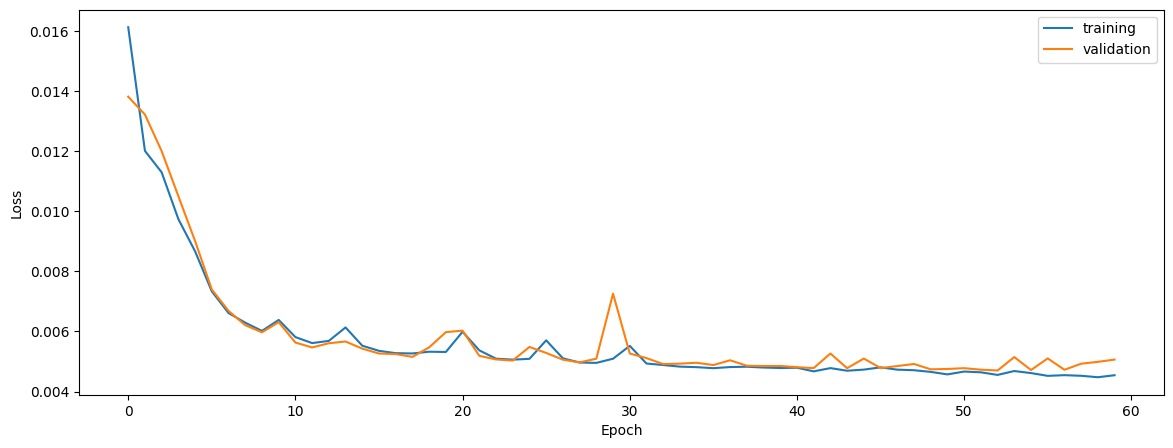

In [6]:
from util import pickleLoad
from visual import plotHistory

history = pickleLoad(path+'/{}.pkl'.format(HASHID))
plotHistory(history)

In [7]:
from util import getPearson, predictInBatches

train_pred = predictInBatches(model,train[0],architecture['batch_size'])
val_pred = predictInBatches(model,val[0],architecture['batch_size'])
test_pred = predictInBatches(model,test[0],architecture['batch_size'])

print('train')
print(getPearson(train[1],train_pred))
print(getPearson(val[1],val_pred))
print(getPearson(test[1],test_pred))

train
0.7925477196275683
0.8087442084433638
0.7368010407832436


In [8]:
print('native')
print(getPearson(train[1],train_pred))
print(getPearson(val[1],val_pred))
print(getPearson(test[1],test_pred))

native
0.7925477196275683
0.8087442084433638
0.7368010407832436


In [9]:
print('normalized')
print(getPearson(train[1][train[2]],train_pred[train[2]]))
print(getPearson(val[1][val[2]],val_pred[val[2]]))
print(getPearson(test[1][test[2]],test_pred[test[2]]))

normalized
0.7805251282930732
0.7948536195002697
0.7324352427978971


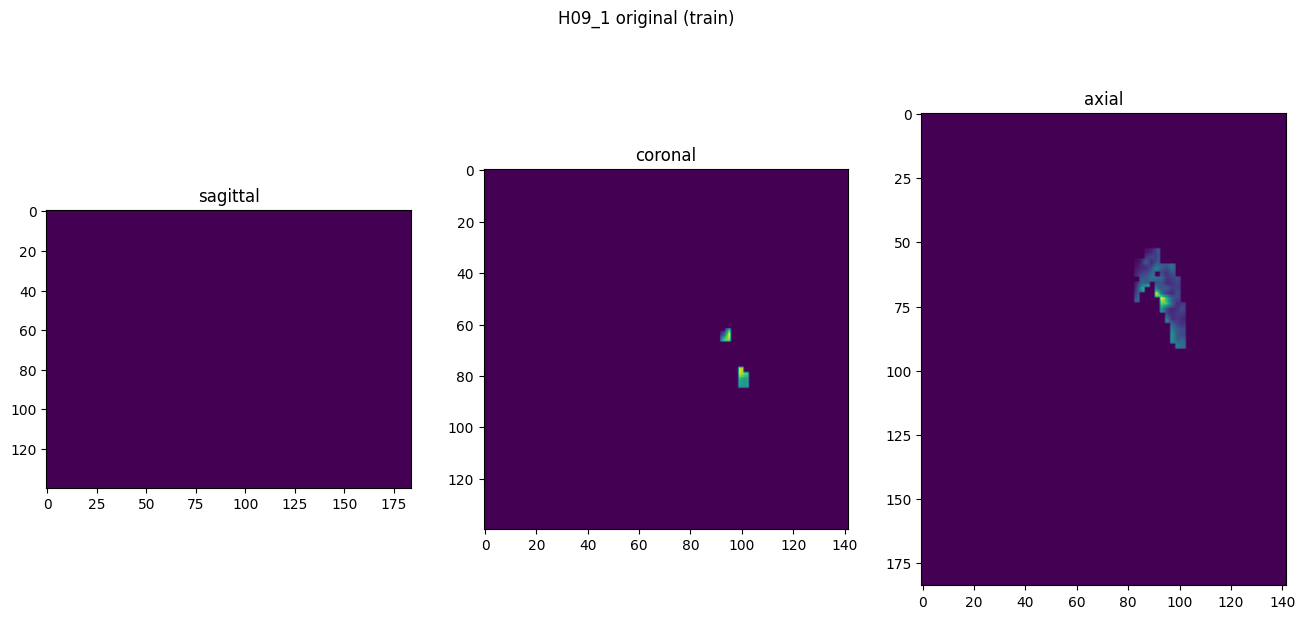

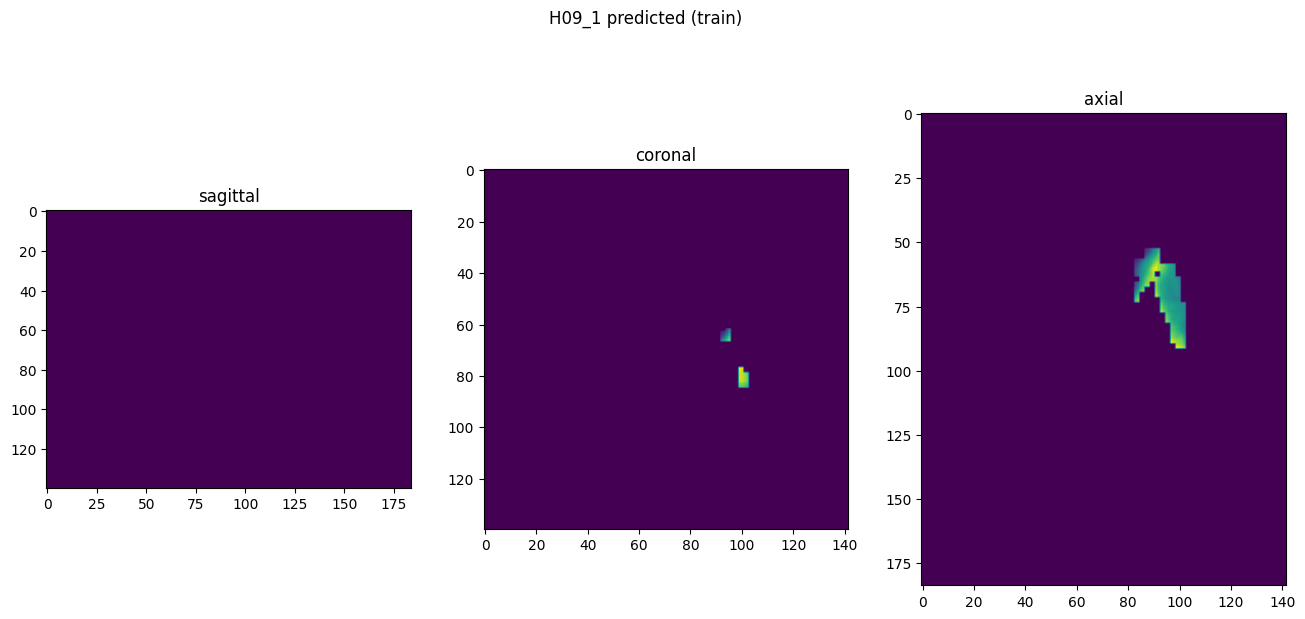

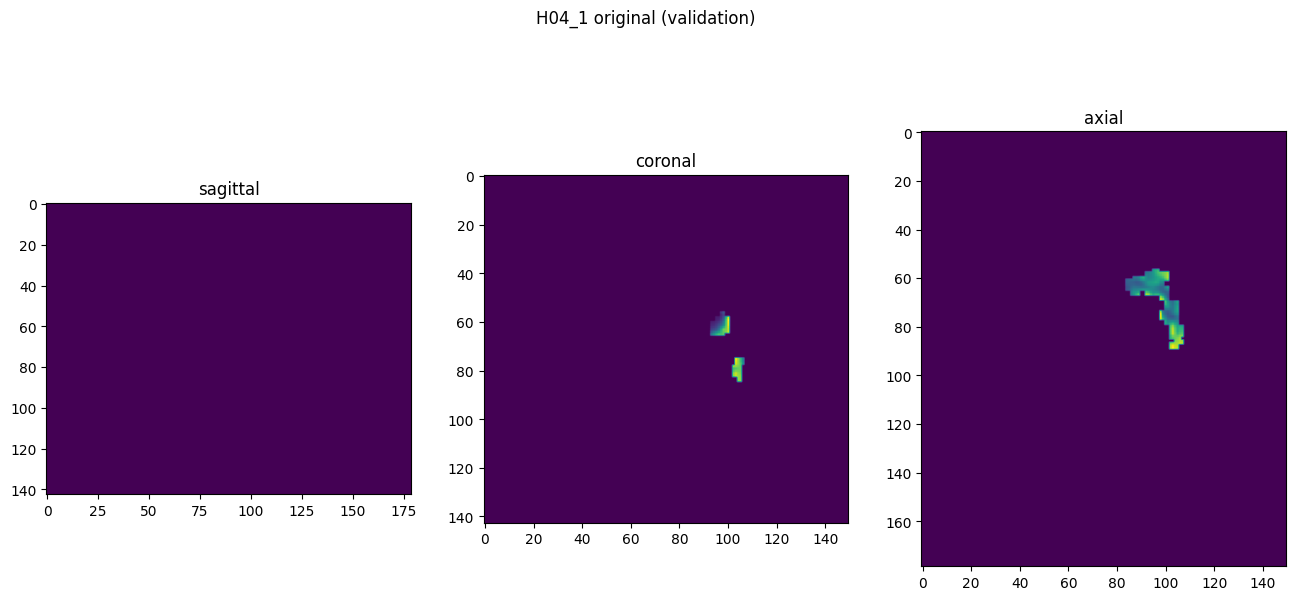

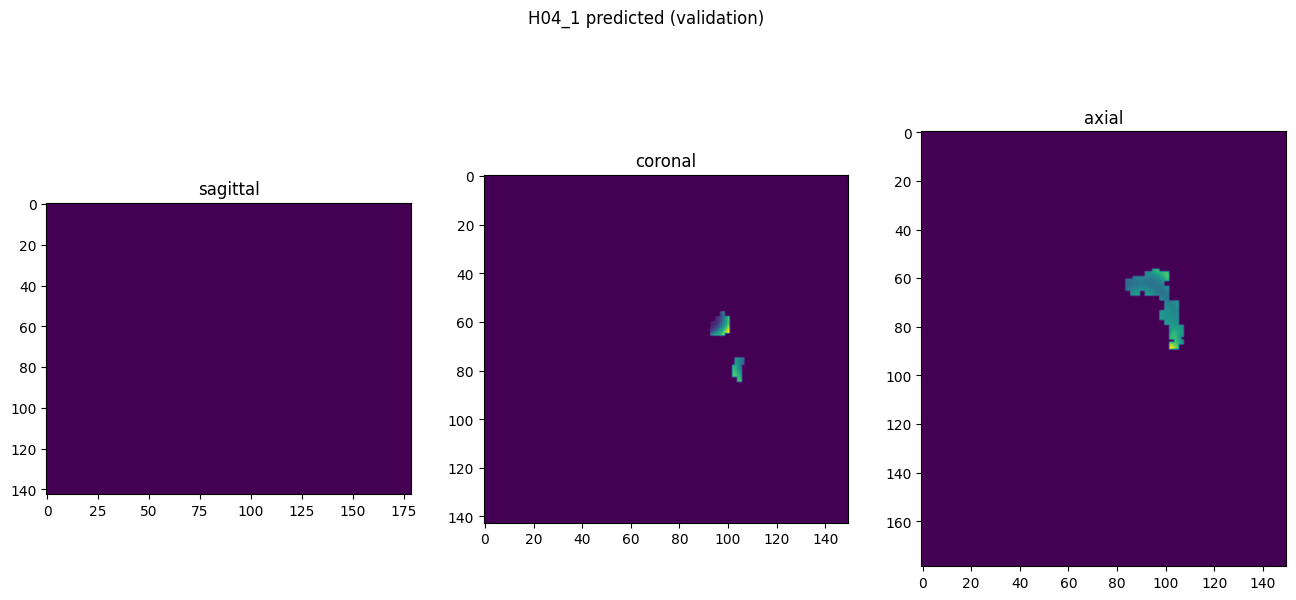

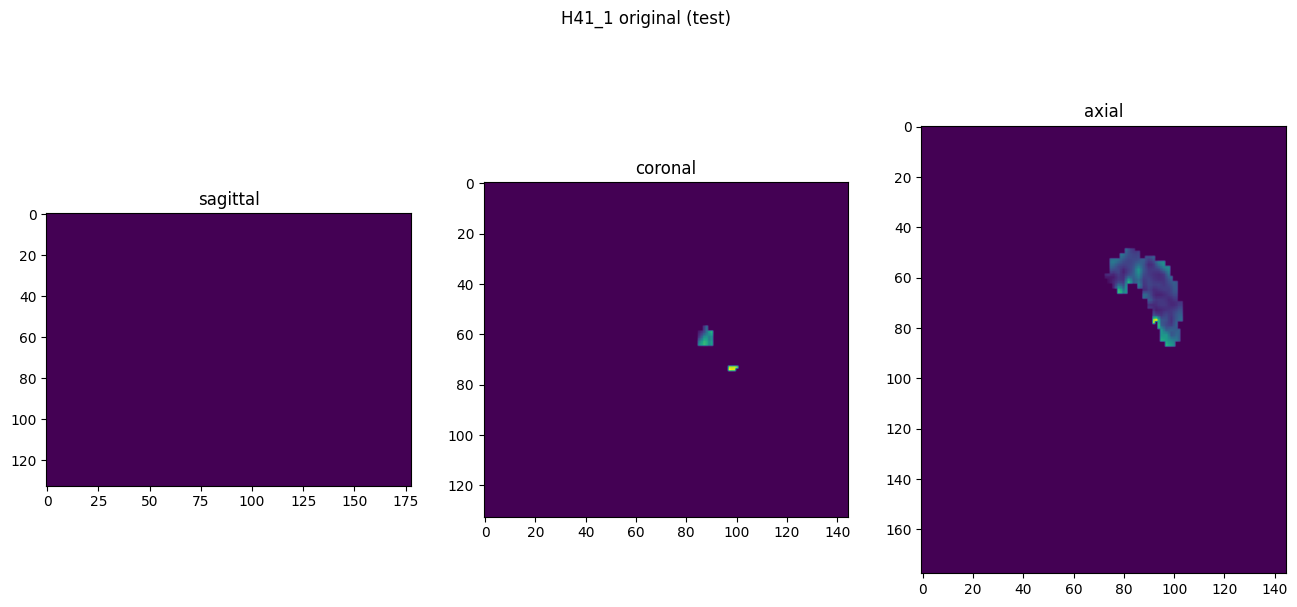

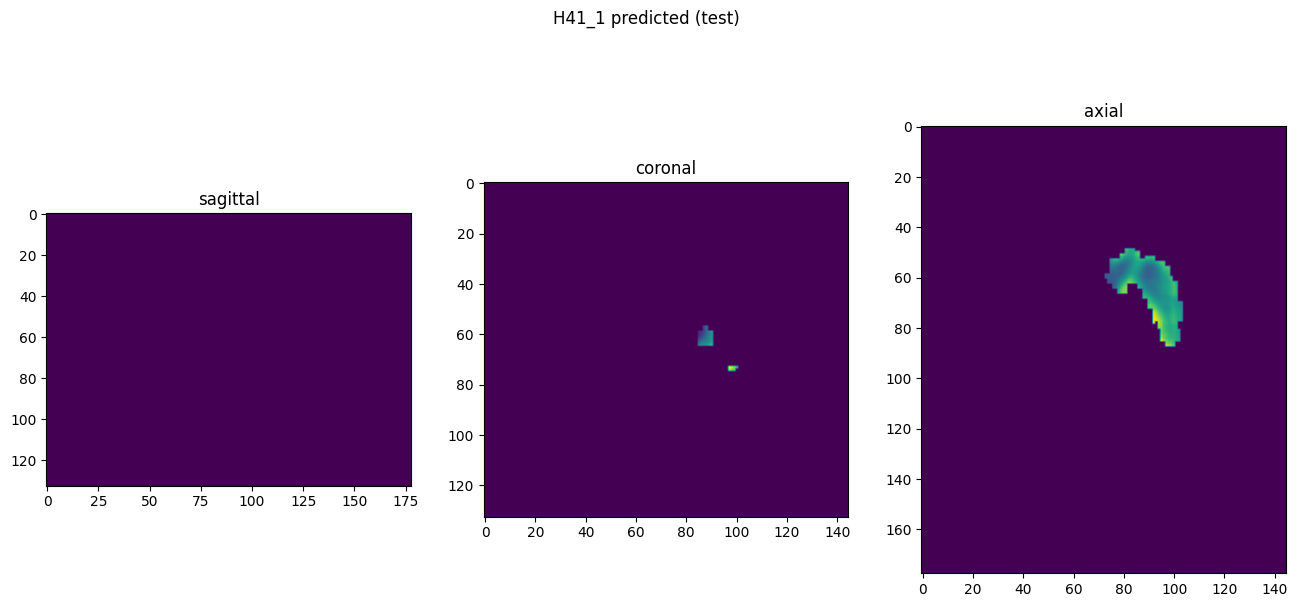

In [10]:
showResults(model, gen, threshold=None, background=False)